In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"✅ TensorFlow has access to {len(gpus)} GPU(s):")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
else:
    print("❌ No GPUs found. TensorFlow is using the CPU.")



2025-05-09 17:47:00.977336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 17:47:00.980275: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 17:47:00.984496: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 17:47:00.994453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746834421.011982    7976 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746834421.01

TensorFlow version: 2.19.0
❌ No GPUs found. TensorFlow is using the CPU.


E0000 00:00:1746834423.596632    7976 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1746834423.596898    7976 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746834423.627109    7976 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
# Parameters
var_list = ["default1", "default2"]
plevel_list = [False, 300]
aew_subset = "default_subset"
model_save_name = "default_modelbase1.keras"
tuner_project_name = "default_tuner_run1"






In [3]:
# Parameters
# Parameters
var_list = ["cape", "crr", "d", "ie", "ishf", "lsrr", "pv", "q","r", "sp", "sstk", "tcw", "tcwv", "t", "ttr", "u","v", "vo","w"] #ERA5 variables



plevel_list = [False, False,300, False, False, False, 300, 300, 300,False, False, False, False, 300,  False, 300,300  ,  300, 300] #pressure levels of variables

aew_subset = "12hr_before"
model_save_name = "best_model_var(300)1.keras"
tuner_project_name = "tuner_run(300)1"


In [4]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

In [5]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [6]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [7]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [8]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [9]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [10]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [11]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [12]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [13]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [14]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [15]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [16]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [17]:
number_of_features = len(var_list)

In [18]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading q_300 from Zarr store.
Loading r_300 from Zarr store.
Loading sp from Zarr store.
Loading sstk from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading v_300 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.


In [19]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 19)


In [20]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






In [21]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(560, 32, 32, 19) (140, 32, 32, 19) (560,) (140,)


In [22]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [23]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(560, 32, 32, 19) (560, 1) (140, 32, 32, 19) (140, 1)


In [24]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 91 (16.25% of total)


In [25]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.1625, 1: 0.8375}


In [26]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

In [27]:
# Build CNN using keras-tuner

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # start building model
        model = keras.Sequential()

        # input
        model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

        # data augmentation layers
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

       


        # things to tune
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice(
            "activation",
            ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"]
        )

        # hidden layers
        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        # Now that we have 4x4 feature maps, now apply global max pooling.
        model.add(layers.GlobalMaxPooling2D())

        # Finally, we add last fully connected (dense) layers
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="binary_crossentropy",
            metrics=METRICS
        )
        return model


In [28]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [29]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=100,
    project_name=tuner_project_name,    # Use the passed parameter
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [30]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 100 Complete [00h 00m 38s]
val_f1_score: 0.4999999403953552

Best val_f1_score So Far: 0.7272726893424988
Total elapsed time: 01h 00m 03s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 19)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 19)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 28)     │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 22)     │         5,566 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 22)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 22)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 22)       │         4,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 22)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 22)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 22)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 67)             │         1,541 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,369 (63.94 KB)

 Trainable params: 16,369 (63.94 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - auc: 0.6576 - binary_accuracy: 0.5227 - cross entropy: 2.0139 - f1_score: 0.2759 - fn: 3.0000 - fp: 39.0000 - loss: 0.3849 - mean_squared_error: 0.4077 - prc: 0.2210 - precision: 0.1702 - recall: 0.7273 - root_mean_squared_error: 0.6385 - tn: 38.0000 - tp: 8.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.6470 - binary_accuracy: 0.4360 - cross entropy: 1.7500 - f1_score: 0.3236 - fn: 5.2000 - fp: 82.4000 - loss: 0.3127 - mean_squared_error: 0.4250 - prc: 0.2469 - precision: 0.2027 - recall: 0.8050 - root_mean_squared_error: 0.6518 - tn: 42.8000 - tp: 21.6000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6326 - binary_accuracy: 0.4562 - cross entropy: 1.5367 - f1_score: 0.3177 - fn: 10.4444 - fp: 105.8889 - loss: 0.2821 - mean_squared_error: 0.3958 - prc: 0.2425 - precision: 0.2024 - recall: 0.7450 - root_mean_squared_error: 0.6284 - tn: 72.4444 - tp: 27.2222

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6334 - binary_accuracy: 0.4992 - cross entropy: 1.3547 - f1_score: 0.3203 - fn: 16.8571 - fp: 124.1429 - loss: 0.2590 - mean_squared_error: 0.3609 - prc: 0.2402 - precision: 0.2091 - recall: 0.6971 - root_mean_squared_error: 0.5989 - tn: 121.5000 - tp: 33.5000

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.6375 - binary_accuracy: 0.5173 - cross entropy: 1.2812 - f1_score: 0.3247 - fn: 19.5294 - fp: 135.3529 - loss: 0.2490 - mean_squared_error: 0.3465 - prc: 0.2400 - precision: 0.2139 - recall: 0.6878 - root_mean_squared_error: 0.5865 - tn: 148.4706 - tp: 37.8235 - val_auc: 0.6583 - val_binary_accuracy: 0.6429 - val_cross entropy: 0.6505 - val_f1_score: 0.2857 - val_fn: 2.0000 - val_fp: 18.0000 - val_loss: 0.6505 - val_mean_squared_error: 0.2290 - val_prc: 0.1909 - val_precision: 0.1818 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4786 - val_tn: 32.0000 - val_tp: 4.0000


Epoch 2/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.7407 - binary_accuracy: 0.7188 - cross entropy: 0.6502 - f1_score: 0.4706 - fn: 1.0000 - fp: 8.0000 - loss: 0.1767 - mean_squared_error: 0.2192 - prc: 0.5984 - precision: 0.3333 - recall: 0.8000 - root_mean_squared_error: 0.4682 - tn: 19.0000 - tp: 4.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8011 - binary_accuracy: 0.6817 - cross entropy: 0.6677 - f1_score: 0.5415 - fn: 1.5000 - fp: 34.8333 - loss: 0.1672 - mean_squared_error: 0.2260 - prc: 0.5170 - precision: 0.3839 - recall: 0.9184 - root_mean_squared_error: 0.4754 - tn: 53.1667 - tp: 22.5000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8136 - binary_accuracy: 0.6753 - cross entropy: 0.6569 - f1_score: 0.5236 - fn: 2.7273 - fp: 60.5455 - loss: 0.1587 - mean_squared_error: 0.2236 - prc: 0.4899 - precision: 0.3663 - recall: 0.9198 - root_mean_squared_error: 0.4729 - tn: 94.6364 - tp: 34.0909

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8206 - binary_accuracy: 0.6792 - cross entropy: 0.6419 - f1_score: 0.5156 - fn: 4.2500 - fp: 82.7500 - loss: 0.1531 - mean_squared_error: 0.2183 - prc: 0.4718 - precision: 0.3593 - recall: 0.9141 - root_mean_squared_error: 0.4671 - tn: 139.5000 - tp: 45.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8212 - binary_accuracy: 0.6799 - cross entropy: 0.6397 - f1_score: 0.5143 - fn: 4.5294 - fp: 86.5294 - loss: 0.1524 - mean_squared_error: 0.2175 - prc: 0.4679 - precision: 0.3583 - recall: 0.9129 - root_mean_squared_error: 0.4663 - tn: 147.2941 - tp: 46.8235 - val_auc: 0.7317 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.4844 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.4844 - val_mean_squared_error: 0.1588 - val_prc: 0.3550 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3985 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 3/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.6704 - binary_accuracy: 0.7812 - cross entropy: 0.5850 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.2335 - mean_squared_error: 0.1846 - prc: 0.2439 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4297 - tn: 22.0000 - tp: 3.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7658 - binary_accuracy: 0.7484 - cross entropy: 0.5278 - f1_score: 0.5259 - fn: 7.5000 - fp: 21.3333 - loss: 0.1913 - mean_squared_error: 0.1755 - prc: 0.4138 - precision: 0.4280 - recall: 0.6831 - root_mean_squared_error: 0.4189 - tn: 66.6667 - tp: 16.5000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7928 - binary_accuracy: 0.7442 - cross entropy: 0.5154 - f1_score: 0.5151 - fn: 11.0000 - fp: 43.0000 - loss: 0.1697 - mean_squared_error: 0.1725 - prc: 0.4323 - precision: 0.4065 - recall: 0.7076 - root_mean_squared_error: 0.4152 - tn: 125.6667 - tp: 28.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8061 - binary_accuracy: 0.7430 - cross entropy: 0.5157 - f1_score: 0.5135 - fn: 12.6471 - fp: 61.4706 - loss: 0.1598 - mean_squared_error: 0.1726 - prc: 0.4434 - precision: 0.3975 - recall: 0.7326 - root_mean_squared_error: 0.4154 - tn: 172.3529 - tp: 38.7059 - val_auc: 0.7183 - val_binary_accuracy: 0.7321 - val_cross entropy: 0.5100 - val_f1_score: 0.2857 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.5100 - val_mean_squared_error: 0.1722 - val_prc: 0.3781 - val_precision: 0.2000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4150 - val_tn: 38.0000 - val_tp: 3.0000


Epoch 4/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7074 - binary_accuracy: 0.7188 - cross entropy: 0.5988 - f1_score: 0.4000 - fn: 2.0000 - fp: 7.0000 - loss: 0.2313 - mean_squared_error: 0.1800 - prc: 0.3195 - precision: 0.3000 - recall: 0.6000 - root_mean_squared_error: 0.4242 - tn: 20.0000 - tp: 3.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7951 - binary_accuracy: 0.7284 - cross entropy: 0.5615 - f1_score: 0.5312 - fn: 6.0000 - fp: 27.8571 - loss: 0.1812 - mean_squared_error: 0.1802 - prc: 0.4261 - precision: 0.4095 - recall: 0.7579 - root_mean_squared_error: 0.4243 - tn: 73.2857 - tp: 20.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8202 - binary_accuracy: 0.7427 - cross entropy: 0.5256 - f1_score: 0.5363 - fn: 8.4615 - fp: 47.0000 - loss: 0.1603 - mean_squared_error: 0.1710 - prc: 0.4460 - precision: 0.4089 - recall: 0.7811 - root_mean_squared_error: 0.4132 - tn: 135.2308 - tp: 33.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8282 - binary_accuracy: 0.7475 - cross entropy: 0.5162 - f1_score: 0.5370 - fn: 10.1176 - fp: 59.2941 - loss: 0.1534 - mean_squared_error: 0.1684 - prc: 0.4481 - precision: 0.4076 - recall: 0.7885 - root_mean_squared_error: 0.4101 - tn: 174.5294 - tp: 41.2353 - val_auc: 0.7250 - val_binary_accuracy: 0.7321 - val_cross entropy: 0.4989 - val_f1_score: 0.2857 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.4989 - val_mean_squared_error: 0.1668 - val_prc: 0.4672 - val_precision: 0.2000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4084 - val_tn: 38.0000 - val_tp: 3.0000


Epoch 5/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7222 - binary_accuracy: 0.7812 - cross entropy: 0.5391 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.2170 - mean_squared_error: 0.1621 - prc: 0.4518 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4027 - tn: 22.0000 - tp: 3.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8259 - binary_accuracy: 0.7528 - cross entropy: 0.5083 - f1_score: 0.5691 - fn: 4.5714 - fp: 27.7143 - loss: 0.1644 - mean_squared_error: 0.1654 - prc: 0.5567 - precision: 0.4400 - recall: 0.8071 - root_mean_squared_error: 0.4066 - tn: 73.4286 - tp: 22.2857

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8441 - binary_accuracy: 0.7495 - cross entropy: 0.5007 - f1_score: 0.5566 - fn: 6.4615 - fp: 50.3077 - loss: 0.1482 - mean_squared_error: 0.1651 - prc: 0.5513 - precision: 0.4203 - recall: 0.8284 - root_mean_squared_error: 0.4063 - tn: 131.9231 - tp: 35.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8519 - binary_accuracy: 0.7512 - cross entropy: 0.4972 - f1_score: 0.5550 - fn: 7.4706 - fp: 63.6471 - loss: 0.1422 - mean_squared_error: 0.1641 - prc: 0.5485 - precision: 0.4159 - recall: 0.8381 - root_mean_squared_error: 0.4051 - tn: 170.1765 - tp: 43.8824 - val_auc: 0.7167 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.4817 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.4817 - val_mean_squared_error: 0.1591 - val_prc: 0.4595 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3988 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 6/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.7037 - binary_accuracy: 0.7812 - cross entropy: 0.5495 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.2294 - mean_squared_error: 0.1648 - prc: 0.4565 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4060 - tn: 22.0000 - tp: 3.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8374 - binary_accuracy: 0.7861 - cross entropy: 0.4700 - f1_score: 0.5931 - fn: 5.1429 - fp: 21.2857 - loss: 0.1658 - mean_squared_error: 0.1497 - prc: 0.5950 - precision: 0.4820 - recall: 0.7716 - root_mean_squared_error: 0.3867 - tn: 79.8571 - tp: 21.7143

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8591 - binary_accuracy: 0.7906 - cross entropy: 0.4537 - f1_score: 0.5938 - fn: 6.9231 - fp: 39.0769 - loss: 0.1462 - mean_squared_error: 0.1466 - prc: 0.6037 - precision: 0.4709 - recall: 0.8067 - root_mean_squared_error: 0.3828 - tn: 143.1538 - tp: 34.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8649 - binary_accuracy: 0.7900 - cross entropy: 0.4501 - f1_score: 0.5905 - fn: 8.0588 - fp: 51.2941 - loss: 0.1400 - mean_squared_error: 0.1462 - prc: 0.5979 - precision: 0.4632 - recall: 0.8187 - root_mean_squared_error: 0.3822 - tn: 182.5294 - tp: 43.2941 - val_auc: 0.7100 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.4921 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.4921 - val_mean_squared_error: 0.1645 - val_prc: 0.4571 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4056 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 7/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7593 - binary_accuracy: 0.8125 - cross entropy: 0.5062 - f1_score: 0.5714 - fn: 1.0000 - fp: 5.0000 - loss: 0.1911 - mean_squared_error: 0.1578 - prc: 0.3864 - precision: 0.4444 - recall: 0.8000 - root_mean_squared_error: 0.3972 - tn: 22.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8666 - binary_accuracy: 0.7917 - cross entropy: 0.4509 - f1_score: 0.6286 - fn: 3.2857 - fp: 24.0000 - loss: 0.1441 - mean_squared_error: 0.1466 - prc: 0.6527 - precision: 0.4934 - recall: 0.8671 - root_mean_squared_error: 0.3829 - tn: 77.1429 - tp: 23.5714

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8785 - binary_accuracy: 0.7864 - cross entropy: 0.4457 - f1_score: 0.6110 - fn: 4.7500 - fp: 40.5833 - loss: 0.1324 - mean_squared_error: 0.1466 - prc: 0.6626 - precision: 0.4708 - recall: 0.8730 - root_mean_squared_error: 0.3828 - tn: 128.0833 - tp: 34.5833

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8836 - binary_accuracy: 0.7858 - cross entropy: 0.4425 - f1_score: 0.6016 - fn: 6.4118 - fp: 55.4706 - loss: 0.1266 - mean_squared_error: 0.1461 - prc: 0.6596 - precision: 0.4600 - recall: 0.8723 - root_mean_squared_error: 0.3822 - tn: 178.3529 - tp: 44.9412 - val_auc: 0.6967 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.4658 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.4658 - val_mean_squared_error: 0.1531 - val_prc: 0.4590 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3913 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 8/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7889 - binary_accuracy: 0.8750 - cross entropy: 0.4617 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.1918 - mean_squared_error: 0.1320 - prc: 0.6504 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.3633 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8742 - binary_accuracy: 0.8118 - cross entropy: 0.4163 - f1_score: 0.6358 - fn: 5.0000 - fp: 20.1429 - loss: 0.1481 - mean_squared_error: 0.1297 - prc: 0.6985 - precision: 0.5284 - recall: 0.8001 - root_mean_squared_error: 0.3602 - tn: 81.0000 - tp: 21.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8826 - binary_accuracy: 0.8021 - cross entropy: 0.4228 - f1_score: 0.6137 - fn: 6.9231 - fp: 39.2308 - loss: 0.1336 - mean_squared_error: 0.1348 - prc: 0.6660 - precision: 0.4926 - recall: 0.8210 - root_mean_squared_error: 0.3671 - tn: 143.0000 - tp: 34.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8848 - binary_accuracy: 0.7980 - cross entropy: 0.4272 - f1_score: 0.6042 - fn: 8.2353 - fp: 51.5882 - loss: 0.1290 - mean_squared_error: 0.1371 - prc: 0.6487 - precision: 0.4786 - recall: 0.8275 - root_mean_squared_error: 0.3701 - tn: 182.2353 - tp: 43.1176 - val_auc: 0.6983 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.4727 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.4727 - val_mean_squared_error: 0.1563 - val_prc: 0.4607 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3953 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 9/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7519 - binary_accuracy: 0.7500 - cross entropy: 0.5024 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.2227 - mean_squared_error: 0.1464 - prc: 0.5824 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.3827 - tn: 21.0000 - tp: 3.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8668 - binary_accuracy: 0.8151 - cross entropy: 0.4232 - f1_score: 0.6412 - fn: 3.7143 - fp: 18.4286 - loss: 0.1541 - mean_squared_error: 0.1313 - prc: 0.6874 - precision: 0.5267 - recall: 0.8208 - root_mean_squared_error: 0.3622 - tn: 82.7143 - tp: 23.1429

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8846 - binary_accuracy: 0.8184 - cross entropy: 0.4139 - f1_score: 0.6410 - fn: 4.7692 - fp: 34.9231 - loss: 0.1349 - mean_squared_error: 0.1305 - prc: 0.6748 - precision: 0.5136 - recall: 0.8565 - root_mean_squared_error: 0.3611 - tn: 147.3077 - tp: 37.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8889 - binary_accuracy: 0.8165 - cross entropy: 0.4147 - f1_score: 0.6342 - fn: 6.0588 - fp: 45.8824 - loss: 0.1292 - mean_squared_error: 0.1314 - prc: 0.6593 - precision: 0.5034 - recall: 0.8611 - root_mean_squared_error: 0.3624 - tn: 187.9412 - tp: 45.2941 - val_auc: 0.6900 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.4880 - val_f1_score: 0.3000 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.4880 - val_mean_squared_error: 0.1617 - val_prc: 0.3930 - val_precision: 0.2143 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4021 - val_tn: 39.0000 - val_tp: 3.0000


Epoch 10/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8000 - binary_accuracy: 0.8438 - cross entropy: 0.4414 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1852 - mean_squared_error: 0.1278 - prc: 0.6696 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3575 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8848 - binary_accuracy: 0.8202 - cross entropy: 0.4222 - f1_score: 0.6688 - fn: 2.2857 - fp: 21.0000 - loss: 0.1405 - mean_squared_error: 0.1298 - prc: 0.6919 - precision: 0.5348 - recall: 0.8936 - root_mean_squared_error: 0.3602 - tn: 80.1429 - tp: 24.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8922 - binary_accuracy: 0.8105 - cross entropy: 0.4271 - f1_score: 0.6434 - fn: 3.9231 - fp: 39.7692 - loss: 0.1279 - mean_squared_error: 0.1339 - prc: 0.6485 - precision: 0.5024 - recall: 0.8981 - root_mean_squared_error: 0.3658 - tn: 142.4615 - tp: 37.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8945 - binary_accuracy: 0.8072 - cross entropy: 0.4263 - f1_score: 0.6324 - fn: 5.2353 - fp: 51.4118 - loss: 0.1235 - mean_squared_error: 0.1347 - prc: 0.6360 - precision: 0.4901 - recall: 0.8950 - root_mean_squared_error: 0.3670 - tn: 182.4118 - tp: 46.1176 - val_auc: 0.6783 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.4718 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.4718 - val_mean_squared_error: 0.1542 - val_prc: 0.3747 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3927 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 11/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8185 - binary_accuracy: 0.8438 - cross entropy: 0.4285 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1786 - mean_squared_error: 0.1259 - prc: 0.7421 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3548 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8893 - binary_accuracy: 0.8365 - cross entropy: 0.4007 - f1_score: 0.6830 - fn: 3.2857 - fp: 17.7143 - loss: 0.1384 - mean_squared_error: 0.1243 - prc: 0.7425 - precision: 0.5636 - recall: 0.8671 - root_mean_squared_error: 0.3525 - tn: 83.4286 - tp: 23.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8985 - binary_accuracy: 0.8333 - cross entropy: 0.4034 - f1_score: 0.6673 - fn: 4.6923 - fp: 33.0769 - loss: 0.1249 - mean_squared_error: 0.1264 - prc: 0.7069 - precision: 0.5388 - recall: 0.8789 - root_mean_squared_error: 0.3555 - tn: 149.1538 - tp: 37.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9009 - binary_accuracy: 0.8331 - cross entropy: 0.4048 - f1_score: 0.6622 - fn: 5.6471 - fp: 42.2941 - loss: 0.1205 - mean_squared_error: 0.1272 - prc: 0.6898 - precision: 0.5309 - recall: 0.8825 - root_mean_squared_error: 0.3567 - tn: 191.5294 - tp: 45.7059 - val_auc: 0.6867 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.4558 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.4558 - val_mean_squared_error: 0.1477 - val_prc: 0.3525 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3843 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 12/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8593 - binary_accuracy: 0.8438 - cross entropy: 0.3795 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1414 - mean_squared_error: 0.1198 - prc: 0.7689 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3461 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9104 - binary_accuracy: 0.8504 - cross entropy: 0.3441 - f1_score: 0.6781 - fn: 5.2857 - fp: 13.5714 - loss: 0.1231 - mean_squared_error: 0.1062 - prc: 0.7738 - precision: 0.6022 - recall: 0.7823 - root_mean_squared_error: 0.3257 - tn: 87.5714 - tp: 21.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9157 - binary_accuracy: 0.8428 - cross entropy: 0.3607 - f1_score: 0.6632 - fn: 6.6923 - fp: 29.3077 - loss: 0.1128 - mean_squared_error: 0.1120 - prc: 0.7282 - precision: 0.5632 - recall: 0.8173 - root_mean_squared_error: 0.3344 - tn: 152.9231 - tp: 35.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9159 - binary_accuracy: 0.8403 - cross entropy: 0.3684 - f1_score: 0.6569 - fn: 7.8235 - fp: 38.8235 - loss: 0.1100 - mean_squared_error: 0.1145 - prc: 0.7025 - precision: 0.5495 - recall: 0.8275 - root_mean_squared_error: 0.3381 - tn: 195.0000 - tp: 43.5294 - val_auc: 0.6817 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.4510 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.4510 - val_mean_squared_error: 0.1457 - val_prc: 0.3537 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3817 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 13/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7963 - binary_accuracy: 0.8438 - cross entropy: 0.4172 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.2020 - mean_squared_error: 0.1118 - prc: 0.5891 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3343 - tn: 24.0000 - tp: 3.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8874 - binary_accuracy: 0.8459 - cross entropy: 0.3640 - f1_score: 0.6536 - fn: 6.5714 - fp: 12.7143 - loss: 0.1459 - mean_squared_error: 0.1065 - prc: 0.7178 - precision: 0.5977 - recall: 0.7223 - root_mean_squared_error: 0.3264 - tn: 88.4286 - tp: 20.2857

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8968 - binary_accuracy: 0.8409 - cross entropy: 0.3742 - f1_score: 0.6474 - fn: 7.9167 - fp: 25.6667 - loss: 0.1312 - mean_squared_error: 0.1117 - prc: 0.6940 - precision: 0.5659 - recall: 0.7655 - root_mean_squared_error: 0.3340 - tn: 143.0000 - tp: 31.4167

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9021 - binary_accuracy: 0.8364 - cross entropy: 0.3798 - f1_score: 0.6411 - fn: 9.0000 - fp: 38.8235 - loss: 0.1231 - mean_squared_error: 0.1149 - prc: 0.6843 - precision: 0.5447 - recall: 0.7918 - root_mean_squared_error: 0.3388 - tn: 195.0000 - tp: 42.3529 - val_auc: 0.6650 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4331 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.4331 - val_mean_squared_error: 0.1359 - val_prc: 0.3563 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3686 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 14/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8259 - binary_accuracy: 0.8750 - cross entropy: 0.3352 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1631 - mean_squared_error: 0.0956 - prc: 0.6747 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3092 - tn: 25.0000 - tp: 3.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8936 - binary_accuracy: 0.8821 - cross entropy: 0.3375 - f1_score: 0.7222 - fn: 5.2857 - fp: 9.7143 - loss: 0.1404 - mean_squared_error: 0.0997 - prc: 0.7269 - precision: 0.6853 - recall: 0.7666 - root_mean_squared_error: 0.3157 - tn: 91.4286 - tp: 21.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8964 - binary_accuracy: 0.8616 - cross entropy: 0.3730 - f1_score: 0.6910 - fn: 6.3846 - fp: 27.1538 - loss: 0.1283 - mean_squared_error: 0.1119 - prc: 0.6635 - precision: 0.6119 - recall: 0.8136 - root_mean_squared_error: 0.3337 - tn: 155.0769 - tp: 35.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8984 - binary_accuracy: 0.8540 - cross entropy: 0.3856 - f1_score: 0.6792 - fn: 6.9412 - fp: 38.1765 - loss: 0.1235 - mean_squared_error: 0.1164 - prc: 0.6455 - precision: 0.5854 - recall: 0.8325 - root_mean_squared_error: 0.3404 - tn: 195.6471 - tp: 44.4118 - val_auc: 0.6883 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4298 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.4298 - val_mean_squared_error: 0.1357 - val_prc: 0.3839 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3684 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 15/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8519 - binary_accuracy: 0.9062 - cross entropy: 0.3521 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.1619 - mean_squared_error: 0.0991 - prc: 0.7670 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.3148 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9036 - binary_accuracy: 0.8892 - cross entropy: 0.3277 - f1_score: 0.7502 - fn: 4.7143 - fp: 9.7143 - loss: 0.1355 - mean_squared_error: 0.0978 - prc: 0.7807 - precision: 0.6934 - recall: 0.8179 - root_mean_squared_error: 0.3127 - tn: 91.4286 - tp: 22.1429

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9094 - binary_accuracy: 0.8777 - cross entropy: 0.3341 - f1_score: 0.7241 - fn: 6.1667 - fp: 20.9167 - loss: 0.1229 - mean_squared_error: 0.1014 - prc: 0.7451 - precision: 0.6444 - recall: 0.8334 - root_mean_squared_error: 0.3182 - tn: 147.7500 - tp: 33.1667

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9116 - binary_accuracy: 0.8683 - cross entropy: 0.3437 - f1_score: 0.7055 - fn: 7.1765 - fp: 33.2941 - loss: 0.1165 - mean_squared_error: 0.1053 - prc: 0.7201 - precision: 0.6104 - recall: 0.8471 - root_mean_squared_error: 0.3242 - tn: 200.5294 - tp: 44.1765 - val_auc: 0.6767 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.4903 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.4903 - val_mean_squared_error: 0.1616 - val_prc: 0.3597 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4020 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 16/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8444 - binary_accuracy: 0.8438 - cross entropy: 0.4052 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1449 - mean_squared_error: 0.1311 - prc: 0.7350 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3620 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9069 - binary_accuracy: 0.8382 - cross entropy: 0.3655 - f1_score: 0.6801 - fn: 4.0000 - fp: 16.7143 - loss: 0.1185 - mean_squared_error: 0.1166 - prc: 0.7620 - precision: 0.5685 - recall: 0.8482 - root_mean_squared_error: 0.3413 - tn: 84.4286 - tp: 22.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.8298 - cross entropy: 0.3675 - f1_score: 0.6535 - fn: 6.5385 - fp: 32.6923 - loss: 0.1100 - mean_squared_error: 0.1173 - prc: 0.7317 - precision: 0.5345 - recall: 0.8442 - root_mean_squared_error: 0.3424 - tn: 149.5385 - tp: 35.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9153 - binary_accuracy: 0.8279 - cross entropy: 0.3685 - f1_score: 0.6451 - fn: 8.0000 - fp: 42.3529 - loss: 0.1072 - mean_squared_error: 0.1178 - prc: 0.7210 - precision: 0.5232 - recall: 0.8445 - root_mean_squared_error: 0.3431 - tn: 191.4706 - tp: 43.3529 - val_auc: 0.6783 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.4781 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.4781 - val_mean_squared_error: 0.1564 - val_prc: 0.3706 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3955 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 17/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8815 - binary_accuracy: 0.8125 - cross entropy: 0.3455 - f1_score: 0.5714 - fn: 1.0000 - fp: 5.0000 - loss: 0.1291 - mean_squared_error: 0.1120 - prc: 0.7589 - precision: 0.4444 - recall: 0.8000 - root_mean_squared_error: 0.3347 - tn: 22.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9087 - binary_accuracy: 0.8233 - cross entropy: 0.3694 - f1_score: 0.6594 - fn: 3.7143 - fp: 18.4286 - loss: 0.1150 - mean_squared_error: 0.1191 - prc: 0.7461 - precision: 0.5418 - recall: 0.8444 - root_mean_squared_error: 0.3451 - tn: 82.7143 - tp: 23.1429

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9146 - binary_accuracy: 0.8193 - cross entropy: 0.3802 - f1_score: 0.6450 - fn: 5.0769 - fp: 35.6923 - loss: 0.1073 - mean_squared_error: 0.1228 - prc: 0.7339 - precision: 0.5162 - recall: 0.8641 - root_mean_squared_error: 0.3503 - tn: 146.5385 - tp: 36.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9167 - binary_accuracy: 0.8206 - cross entropy: 0.3795 - f1_score: 0.6422 - fn: 6.1176 - fp: 45.0000 - loss: 0.1045 - mean_squared_error: 0.1225 - prc: 0.7272 - precision: 0.5107 - recall: 0.8691 - root_mean_squared_error: 0.3500 - tn: 188.8235 - tp: 45.2353 - val_auc: 0.6617 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4485 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.4485 - val_mean_squared_error: 0.1429 - val_prc: 0.3415 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 18/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.8963 - binary_accuracy: 0.9375 - cross entropy: 0.2984 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.1211 - mean_squared_error: 0.0873 - prc: 0.8486 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2955 - tn: 26.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9338 - binary_accuracy: 0.9019 - cross entropy: 0.3031 - f1_score: 0.7897 - fn: 2.2857 - fp: 11.1429 - loss: 0.1046 - mean_squared_error: 0.0922 - prc: 0.8218 - precision: 0.7116 - recall: 0.8936 - root_mean_squared_error: 0.3036 - tn: 90.0000 - tp: 24.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9318 - binary_accuracy: 0.8823 - cross entropy: 0.3260 - f1_score: 0.7474 - fn: 3.4615 - fp: 25.6923 - loss: 0.0995 - mean_squared_error: 0.1008 - prc: 0.7735 - precision: 0.6429 - recall: 0.9055 - root_mean_squared_error: 0.3171 - tn: 156.5385 - tp: 38.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9312 - binary_accuracy: 0.8765 - cross entropy: 0.3324 - f1_score: 0.7328 - fn: 4.4118 - fp: 34.1176 - loss: 0.0977 - mean_squared_error: 0.1031 - prc: 0.7571 - precision: 0.6210 - recall: 0.9064 - root_mean_squared_error: 0.3207 - tn: 199.7059 - tp: 46.9412 - val_auc: 0.6600 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.4901 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.4901 - val_mean_squared_error: 0.1566 - val_prc: 0.3395 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3957 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 19/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9074 - binary_accuracy: 0.8750 - cross entropy: 0.3007 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.1022 - mean_squared_error: 0.0957 - prc: 0.8529 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.3093 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9410 - binary_accuracy: 0.8826 - cross entropy: 0.3038 - f1_score: 0.7522 - fn: 2.7143 - fp: 12.0000 - loss: 0.0927 - mean_squared_error: 0.0933 - prc: 0.8202 - precision: 0.6554 - recall: 0.8828 - root_mean_squared_error: 0.3054 - tn: 89.1429 - tp: 24.1429

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9395 - binary_accuracy: 0.8738 - cross entropy: 0.3259 - f1_score: 0.7297 - fn: 3.7692 - fp: 25.5385 - loss: 0.0906 - mean_squared_error: 0.0999 - prc: 0.7689 - precision: 0.6167 - recall: 0.8979 - root_mean_squared_error: 0.3159 - tn: 156.6923 - tp: 38.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9398 - binary_accuracy: 0.8715 - cross entropy: 0.3308 - f1_score: 0.7221 - fn: 4.4706 - fp: 33.4118 - loss: 0.0893 - mean_squared_error: 0.1015 - prc: 0.7540 - precision: 0.6039 - recall: 0.9027 - root_mean_squared_error: 0.3183 - tn: 200.4118 - tp: 46.8824 - val_auc: 0.6700 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4429 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4429 - val_mean_squared_error: 0.1367 - val_prc: 0.3573 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3697 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 20/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.8852 - binary_accuracy: 0.8750 - cross entropy: 0.2996 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.1283 - mean_squared_error: 0.0919 - prc: 0.8027 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.3032 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9256 - binary_accuracy: 0.8882 - cross entropy: 0.2931 - f1_score: 0.7577 - fn: 3.2857 - fp: 11.0000 - loss: 0.1140 - mean_squared_error: 0.0863 - prc: 0.8069 - precision: 0.6736 - recall: 0.8671 - root_mean_squared_error: 0.2937 - tn: 90.1429 - tp: 23.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9274 - binary_accuracy: 0.8740 - cross entropy: 0.3203 - f1_score: 0.7268 - fn: 4.4615 - fp: 25.4615 - loss: 0.1053 - mean_squared_error: 0.0950 - prc: 0.7618 - precision: 0.6213 - recall: 0.8826 - root_mean_squared_error: 0.3077 - tn: 156.7692 - tp: 37.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9276 - binary_accuracy: 0.8692 - cross entropy: 0.3294 - f1_score: 0.7149 - fn: 5.4118 - fp: 34.1765 - loss: 0.1024 - mean_squared_error: 0.0983 - prc: 0.7447 - precision: 0.6028 - recall: 0.8861 - root_mean_squared_error: 0.3131 - tn: 199.6471 - tp: 45.9412 - val_auc: 0.6800 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4369 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4369 - val_mean_squared_error: 0.1359 - val_prc: 0.3585 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3686 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 21/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.8963 - binary_accuracy: 0.9062 - cross entropy: 0.2759 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.1188 - mean_squared_error: 0.0790 - prc: 0.8486 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2811 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9232 - binary_accuracy: 0.8954 - cross entropy: 0.2977 - f1_score: 0.7650 - fn: 4.4286 - fp: 9.8571 - loss: 0.1128 - mean_squared_error: 0.0873 - prc: 0.8048 - precision: 0.7067 - recall: 0.8357 - root_mean_squared_error: 0.2952 - tn: 91.2857 - tp: 22.4286

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9232 - binary_accuracy: 0.8749 - cross entropy: 0.3339 - f1_score: 0.7238 - fn: 5.6154 - fp: 25.3846 - loss: 0.1065 - mean_squared_error: 0.1001 - prc: 0.7575 - precision: 0.6342 - recall: 0.8556 - root_mean_squared_error: 0.3154 - tn: 156.8462 - tp: 36.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9243 - binary_accuracy: 0.8690 - cross entropy: 0.3439 - f1_score: 0.7113 - fn: 6.2941 - fp: 34.5294 - loss: 0.1035 - mean_squared_error: 0.1037 - prc: 0.7449 - precision: 0.6110 - recall: 0.8654 - root_mean_squared_error: 0.3212 - tn: 199.2941 - tp: 45.0588 - val_auc: 0.6750 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.4072 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.4072 - val_mean_squared_error: 0.1242 - val_prc: 0.3525 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3524 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 22/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8889 - binary_accuracy: 0.9375 - cross entropy: 0.2511 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.1297 - mean_squared_error: 0.0664 - prc: 0.8461 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2578 - tn: 26.0000 - tp: 4.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9354 - binary_accuracy: 0.9126 - cross entropy: 0.2524 - f1_score: 0.7906 - fn: 5.0000 - fp: 8.6250 - loss: 0.1089 - mean_squared_error: 0.0733 - prc: 0.8492 - precision: 0.7659 - recall: 0.8212 - root_mean_squared_error: 0.2704 - tn: 106.2500 - tp: 24.1250

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9341 - binary_accuracy: 0.8906 - cross entropy: 0.2858 - f1_score: 0.7475 - fn: 6.2143 - fp: 23.5714 - loss: 0.1020 - mean_squared_error: 0.0854 - prc: 0.7984 - precision: 0.6816 - recall: 0.8453 - root_mean_squared_error: 0.2911 - tn: 172.0714 - tp: 38.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9338 - binary_accuracy: 0.8842 - cross entropy: 0.2962 - f1_score: 0.7347 - fn: 6.7059 - fp: 30.5882 - loss: 0.0999 - mean_squared_error: 0.0891 - prc: 0.7826 - precision: 0.6570 - recall: 0.8537 - root_mean_squared_error: 0.2973 - tn: 203.2353 - tp: 44.6471 - val_auc: 0.6850 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.4367 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.4367 - val_mean_squared_error: 0.1365 - val_prc: 0.3563 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3694 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 23/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.8741 - binary_accuracy: 0.9062 - cross entropy: 0.3100 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.1323 - mean_squared_error: 0.0943 - prc: 0.7732 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.3070 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9336 - binary_accuracy: 0.8847 - cross entropy: 0.2681 - f1_score: 0.7417 - fn: 5.2857 - fp: 10.1429 - loss: 0.1073 - mean_squared_error: 0.0827 - prc: 0.8405 - precision: 0.6824 - recall: 0.8132 - root_mean_squared_error: 0.2874 - tn: 91.0000 - tp: 21.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.8720 - cross entropy: 0.2905 - f1_score: 0.7086 - fn: 7.6923 - fp: 22.9231 - loss: 0.1006 - mean_squared_error: 0.0901 - prc: 0.7949 - precision: 0.6292 - recall: 0.8164 - root_mean_squared_error: 0.2996 - tn: 159.3077 - tp: 34.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9331 - binary_accuracy: 0.8661 - cross entropy: 0.3041 - f1_score: 0.6963 - fn: 8.6471 - fp: 32.2353 - loss: 0.0981 - mean_squared_error: 0.0945 - prc: 0.7795 - precision: 0.6062 - recall: 0.8261 - root_mean_squared_error: 0.3067 - tn: 201.5882 - tp: 42.7059 - val_auc: 0.6683 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.4690 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.4690 - val_mean_squared_error: 0.1486 - val_prc: 0.3464 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3855 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 24/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2573 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0863 - mean_squared_error: 0.0823 - prc: 0.8273 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2868 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9393 - binary_accuracy: 0.8875 - cross entropy: 0.2800 - f1_score: 0.7552 - fn: 3.8571 - fp: 11.2857 - loss: 0.1012 - mean_squared_error: 0.0868 - prc: 0.8263 - precision: 0.6791 - recall: 0.8514 - root_mean_squared_error: 0.2945 - tn: 89.8571 - tp: 23.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9350 - binary_accuracy: 0.8752 - cross entropy: 0.3098 - f1_score: 0.7258 - fn: 5.2308 - fp: 24.6154 - loss: 0.0984 - mean_squared_error: 0.0945 - prc: 0.7624 - precision: 0.6280 - recall: 0.8662 - root_mean_squared_error: 0.3071 - tn: 157.6154 - tp: 36.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9339 - binary_accuracy: 0.8702 - cross entropy: 0.3210 - f1_score: 0.7133 - fn: 6.2941 - fp: 33.1765 - loss: 0.0970 - mean_squared_error: 0.0976 - prc: 0.7411 - precision: 0.6083 - recall: 0.8699 - root_mean_squared_error: 0.3120 - tn: 200.6471 - tp: 45.0588 - val_auc: 0.6617 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.4691 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.4691 - val_mean_squared_error: 0.1470 - val_prc: 0.3502 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3834 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 25/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.9037 - binary_accuracy: 0.8750 - cross entropy: 0.3172 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.0982 - mean_squared_error: 0.1033 - prc: 0.7315 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.3214 - tn: 24.0000 - tp: 4.0000

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9449 - binary_accuracy: 0.8779 - cross entropy: 0.2933 - f1_score: 0.7428 - fn: 2.8750 - fp: 14.1250 - loss: 0.0873 - mean_squared_error: 0.0916 - prc: 0.7948 - precision: 0.6394 - recall: 0.8864 - root_mean_squared_error: 0.3025 - tn: 100.7500 - tp: 26.2500

14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9439 - binary_accuracy: 0.8749 - cross entropy: 0.3025 - f1_score: 0.7297 - fn: 4.2143 - fp: 25.9286 - loss: 0.0858 - mean_squared_error: 0.0937 - prc: 0.7591 - precision: 0.6168 - recall: 0.8951 - root_mean_squared_error: 0.3059 - tn: 169.7143 - tp: 40.1429

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9434 - binary_accuracy: 0.8720 - cross entropy: 0.3080 - f1_score: 0.7216 - fn: 4.8824 - fp: 32.3529 - loss: 0.0855 - mean_squared_error: 0.0950 - prc: 0.7464 - precision: 0.6049 - recall: 0.8968 - root_mean_squared_error: 0.3081 - tn: 201.4706 - tp: 46.4706 - val_auc: 0.6733 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4680 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4680 - val_mean_squared_error: 0.1458 - val_prc: 0.3675 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3818 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 26/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9148 - binary_accuracy: 0.9062 - cross entropy: 0.2689 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0908 - mean_squared_error: 0.0843 - prc: 0.8153 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2903 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9384 - binary_accuracy: 0.8926 - cross entropy: 0.2816 - f1_score: 0.7654 - fn: 3.4286 - fp: 10.7143 - loss: 0.0925 - mean_squared_error: 0.0871 - prc: 0.8278 - precision: 0.6886 - recall: 0.8622 - root_mean_squared_error: 0.2951 - tn: 90.4286 - tp: 23.4286

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9382 - binary_accuracy: 0.8775 - cross entropy: 0.3027 - f1_score: 0.7305 - fn: 5.0769 - fp: 24.4615 - loss: 0.0902 - mean_squared_error: 0.0935 - prc: 0.7881 - precision: 0.6323 - recall: 0.8713 - root_mean_squared_error: 0.3054 - tn: 157.7692 - tp: 36.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9381 - binary_accuracy: 0.8718 - cross entropy: 0.3111 - f1_score: 0.7168 - fn: 6.1765 - fp: 33.1176 - loss: 0.0893 - mean_squared_error: 0.0960 - prc: 0.7726 - precision: 0.6113 - recall: 0.8738 - root_mean_squared_error: 0.3095 - tn: 200.7059 - tp: 45.1765 - val_auc: 0.6700 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.4640 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.4640 - val_mean_squared_error: 0.1447 - val_prc: 0.3641 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3804 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 27/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9185 - binary_accuracy: 0.9375 - cross entropy: 0.2741 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0968 - mean_squared_error: 0.0842 - prc: 0.8174 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2901 - tn: 26.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.9110 - cross entropy: 0.2754 - f1_score: 0.8030 - fn: 2.7143 - fp: 9.5714 - loss: 0.0898 - mean_squared_error: 0.0843 - prc: 0.8631 - precision: 0.7391 - recall: 0.8836 - root_mean_squared_error: 0.2904 - tn: 91.5714 - tp: 24.1429

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9469 - binary_accuracy: 0.8972 - cross entropy: 0.2870 - f1_score: 0.7672 - fn: 4.4615 - fp: 20.6923 - loss: 0.0860 - mean_squared_error: 0.0874 - prc: 0.8282 - precision: 0.6808 - recall: 0.8863 - root_mean_squared_error: 0.2955 - tn: 161.5385 - tp: 37.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9473 - binary_accuracy: 0.8929 - cross entropy: 0.2923 - f1_score: 0.7557 - fn: 5.2353 - fp: 27.8235 - loss: 0.0844 - mean_squared_error: 0.0890 - prc: 0.8164 - precision: 0.6605 - recall: 0.8910 - root_mean_squared_error: 0.2982 - tn: 206.0000 - tp: 46.1176 - val_auc: 0.6933 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.4633 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.4633 - val_mean_squared_error: 0.1460 - val_prc: 0.3670 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3821 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 28/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9556 - binary_accuracy: 0.8750 - cross entropy: 0.2319 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.0696 - mean_squared_error: 0.0732 - prc: 0.8856 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.2705 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9595 - binary_accuracy: 0.8715 - cross entropy: 0.2618 - f1_score: 0.7362 - fn: 2.5714 - fp: 13.7143 - loss: 0.0771 - mean_squared_error: 0.0830 - prc: 0.8782 - precision: 0.6294 - recall: 0.8868 - root_mean_squared_error: 0.2880 - tn: 87.4286 - tp: 24.2857

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9564 - binary_accuracy: 0.8647 - cross entropy: 0.2769 - f1_score: 0.7126 - fn: 4.6154 - fp: 26.3846 - loss: 0.0771 - mean_squared_error: 0.0876 - prc: 0.8505 - precision: 0.5973 - recall: 0.8850 - root_mean_squared_error: 0.2958 - tn: 155.8462 - tp: 37.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9557 - binary_accuracy: 0.8651 - cross entropy: 0.2818 - f1_score: 0.7085 - fn: 5.5882 - fp: 33.3529 - loss: 0.0767 - mean_squared_error: 0.0888 - prc: 0.8409 - precision: 0.5905 - recall: 0.8871 - root_mean_squared_error: 0.2978 - tn: 200.4706 - tp: 45.7647 - val_auc: 0.7250 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4625 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4625 - val_mean_squared_error: 0.1451 - val_prc: 0.3665 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3810 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 29/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2733 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0829 - mean_squared_error: 0.0869 - prc: 0.7760 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2948 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9479 - binary_accuracy: 0.8820 - cross entropy: 0.2886 - f1_score: 0.7520 - fn: 2.8571 - fp: 12.7143 - loss: 0.0854 - mean_squared_error: 0.0882 - prc: 0.8106 - precision: 0.6585 - recall: 0.8779 - root_mean_squared_error: 0.2969 - tn: 88.4286 - tp: 24.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9477 - binary_accuracy: 0.8769 - cross entropy: 0.3006 - f1_score: 0.7339 - fn: 4.0769 - fp: 24.3077 - loss: 0.0828 - mean_squared_error: 0.0910 - prc: 0.7794 - precision: 0.6257 - recall: 0.8912 - root_mean_squared_error: 0.3015 - tn: 157.9231 - tp: 37.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9484 - binary_accuracy: 0.8760 - cross entropy: 0.2992 - f1_score: 0.7275 - fn: 5.1176 - fp: 31.0588 - loss: 0.0814 - mean_squared_error: 0.0905 - prc: 0.7725 - precision: 0.6156 - recall: 0.8926 - root_mean_squared_error: 0.3007 - tn: 202.7647 - tp: 46.2353 - val_auc: 0.6867 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.4259 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.4259 - val_mean_squared_error: 0.1296 - val_prc: 0.3740 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3600 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 30/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2274 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0872 - mean_squared_error: 0.0702 - prc: 0.8666 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2649 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9586 - binary_accuracy: 0.8882 - cross entropy: 0.2607 - f1_score: 0.7716 - fn: 1.4286 - fp: 13.4286 - loss: 0.0754 - mean_squared_error: 0.0782 - prc: 0.8552 - precision: 0.6623 - recall: 0.9271 - root_mean_squared_error: 0.2794 - tn: 87.7143 - tp: 25.4286

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9594 - binary_accuracy: 0.8846 - cross entropy: 0.2703 - f1_score: 0.7542 - fn: 2.6154 - fp: 23.9231 - loss: 0.0725 - mean_squared_error: 0.0802 - prc: 0.8246 - precision: 0.6355 - recall: 0.9302 - root_mean_squared_error: 0.2830 - tn: 158.3077 - tp: 39.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9589 - binary_accuracy: 0.8835 - cross entropy: 0.2732 - f1_score: 0.7467 - fn: 3.5882 - fp: 30.4118 - loss: 0.0722 - mean_squared_error: 0.0812 - prc: 0.8137 - precision: 0.6262 - recall: 0.9274 - root_mean_squared_error: 0.2848 - tn: 203.4118 - tp: 47.7647 - val_auc: 0.6817 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4732 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4732 - val_mean_squared_error: 0.1456 - val_prc: 0.3733 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3816 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 31/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9630 - binary_accuracy: 0.8750 - cross entropy: 0.2436 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.0704 - mean_squared_error: 0.0796 - prc: 0.8946 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.2821 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9700 - binary_accuracy: 0.8752 - cross entropy: 0.2601 - f1_score: 0.7440 - fn: 2.1429 - fp: 13.4286 - loss: 0.0685 - mean_squared_error: 0.0801 - prc: 0.8863 - precision: 0.6353 - recall: 0.8976 - root_mean_squared_error: 0.2830 - tn: 87.7143 - tp: 24.7143

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9673 - binary_accuracy: 0.8815 - cross entropy: 0.2643 - f1_score: 0.7439 - fn: 3.5385 - fp: 22.0769 - loss: 0.0680 - mean_squared_error: 0.0799 - prc: 0.8530 - precision: 0.6316 - recall: 0.9050 - root_mean_squared_error: 0.2826 - tn: 160.1538 - tp: 38.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9660 - binary_accuracy: 0.8838 - cross entropy: 0.2664 - f1_score: 0.7434 - fn: 4.2941 - fp: 27.7059 - loss: 0.0679 - mean_squared_error: 0.0802 - prc: 0.8388 - precision: 0.6294 - recall: 0.9081 - root_mean_squared_error: 0.2831 - tn: 206.1176 - tp: 47.0588 - val_auc: 0.7400 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4583 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4583 - val_mean_squared_error: 0.1425 - val_prc: 0.3572 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3775 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 32/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9704 - binary_accuracy: 0.8750 - cross entropy: 0.2416 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.0630 - mean_squared_error: 0.0799 - prc: 0.9058 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.2826 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.8926 - cross entropy: 0.2363 - f1_score: 0.7717 - fn: 1.8571 - fp: 11.1429 - loss: 0.0644 - mean_squared_error: 0.0748 - prc: 0.9120 - precision: 0.6732 - recall: 0.9044 - root_mean_squared_error: 0.2734 - tn: 90.0000 - tp: 25.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9703 - binary_accuracy: 0.8932 - cross entropy: 0.2442 - f1_score: 0.7641 - fn: 3.0000 - fp: 20.4615 - loss: 0.0646 - mean_squared_error: 0.0761 - prc: 0.8866 - precision: 0.6565 - recall: 0.9152 - root_mean_squared_error: 0.2759 - tn: 161.7692 - tp: 38.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9690 - binary_accuracy: 0.8937 - cross entropy: 0.2476 - f1_score: 0.7612 - fn: 3.6471 - fp: 26.2353 - loss: 0.0647 - mean_squared_error: 0.0767 - prc: 0.8738 - precision: 0.6503 - recall: 0.9188 - root_mean_squared_error: 0.2768 - tn: 207.5882 - tp: 47.7059 - val_auc: 0.7250 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4027 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4027 - val_mean_squared_error: 0.1213 - val_prc: 0.3940 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3483 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 33/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.2086 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0598 - mean_squared_error: 0.0657 - prc: 0.9199 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2563 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.8954 - cross entropy: 0.2473 - f1_score: 0.7735 - fn: 2.7143 - fp: 10.8571 - loss: 0.0706 - mean_squared_error: 0.0763 - prc: 0.8786 - precision: 0.6894 - recall: 0.8819 - root_mean_squared_error: 0.2761 - tn: 90.2857 - tp: 24.1429

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9626 - binary_accuracy: 0.8891 - cross entropy: 0.2643 - f1_score: 0.7534 - fn: 4.0769 - fp: 21.6154 - loss: 0.0701 - mean_squared_error: 0.0805 - prc: 0.8484 - precision: 0.6536 - recall: 0.8923 - root_mean_squared_error: 0.2835 - tn: 160.6154 - tp: 37.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9615 - binary_accuracy: 0.8880 - cross entropy: 0.2685 - f1_score: 0.7478 - fn: 4.7647 - fp: 28.0588 - loss: 0.0699 - mean_squared_error: 0.0814 - prc: 0.8353 - precision: 0.6425 - recall: 0.8976 - root_mean_squared_error: 0.2851 - tn: 205.7647 - tp: 46.5882 - val_auc: 0.7417 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4341 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4341 - val_mean_squared_error: 0.1366 - val_prc: 0.3650 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3696 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 34/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9593 - binary_accuracy: 0.8438 - cross entropy: 0.2623 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.0609 - mean_squared_error: 0.0831 - prc: 0.8305 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.2882 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9655 - binary_accuracy: 0.8877 - cross entropy: 0.2565 - f1_score: 0.7637 - fn: 1.8571 - fp: 11.7143 - loss: 0.0664 - mean_squared_error: 0.0725 - prc: 0.8406 - precision: 0.6624 - recall: 0.9044 - root_mean_squared_error: 0.2689 - tn: 89.4286 - tp: 25.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9640 - binary_accuracy: 0.8951 - cross entropy: 0.2708 - f1_score: 0.7700 - fn: 2.3077 - fp: 19.8462 - loss: 0.0667 - mean_squared_error: 0.0752 - prc: 0.8129 - precision: 0.6598 - recall: 0.9263 - root_mean_squared_error: 0.2740 - tn: 162.3846 - tp: 39.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9634 - binary_accuracy: 0.8980 - cross entropy: 0.2731 - f1_score: 0.7721 - fn: 2.6471 - fp: 24.8235 - loss: 0.0667 - mean_squared_error: 0.0757 - prc: 0.8049 - precision: 0.6594 - recall: 0.9330 - root_mean_squared_error: 0.2750 - tn: 209.0000 - tp: 48.7059 - val_auc: 0.7117 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4684 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4684 - val_mean_squared_error: 0.1425 - val_prc: 0.3951 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3775 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 35/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.1733 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0391 - mean_squared_error: 0.0533 - prc: 0.9635 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2310 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9751 - binary_accuracy: 0.8968 - cross entropy: 0.2428 - f1_score: 0.7935 - fn: 1.1429 - fp: 12.4286 - loss: 0.0589 - mean_squared_error: 0.0729 - prc: 0.8989 - precision: 0.6764 - recall: 0.9597 - root_mean_squared_error: 0.2694 - tn: 88.7143 - tp: 25.7143   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9724 - binary_accuracy: 0.9028 - cross entropy: 0.2452 - f1_score: 0.7900 - fn: 2.3077 - fp: 19.0000 - loss: 0.0604 - mean_squared_error: 0.0718 - prc: 0.8715 - precision: 0.6762 - recall: 0.9502 - root_mean_squared_error: 0.2676 - tn: 163.2308 - tp: 39.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9711 - binary_accuracy: 0.9038 - cross entropy: 0.2476 - f1_score: 0.7865 - fn: 2.9412 - fp: 23.9412 - loss: 0.0609 - mean_squared_error: 0.0720 - prc: 0.8583 - precision: 0.6723 - recall: 0.9476 - root_mean_squared_error: 0.2681 - tn: 209.8824 - tp: 48.4118 - val_auc: 0.7483 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4631 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4631 - val_mean_squared_error: 0.1442 - val_prc: 0.3571 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3798 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 36/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2305 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0708 - mean_squared_error: 0.0759 - prc: 0.8856 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2754 - tn: 25.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9663 - binary_accuracy: 0.9080 - cross entropy: 0.2361 - f1_score: 0.8026 - fn: 1.2857 - fp: 10.5714 - loss: 0.0656 - mean_squared_error: 0.0736 - prc: 0.8917 - precision: 0.7059 - recall: 0.9311 - root_mean_squared_error: 0.2712 - tn: 90.5714 - tp: 25.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9661 - binary_accuracy: 0.9005 - cross entropy: 0.2456 - f1_score: 0.7803 - fn: 2.3077 - fp: 20.8462 - loss: 0.0646 - mean_squared_error: 0.0760 - prc: 0.8744 - precision: 0.6704 - recall: 0.9359 - root_mean_squared_error: 0.2756 - tn: 161.3846 - tp: 39.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9659 - binary_accuracy: 0.9001 - cross entropy: 0.2477 - f1_score: 0.7756 - fn: 2.8824 - fp: 26.3529 - loss: 0.0642 - mean_squared_error: 0.0761 - prc: 0.8657 - precision: 0.6627 - recall: 0.9374 - root_mean_squared_error: 0.2759 - tn: 207.4706 - tp: 48.4706 - val_auc: 0.7217 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.5137 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5137 - val_mean_squared_error: 0.1566 - val_prc: 0.3805 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3957 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 37/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.2841 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0596 - mean_squared_error: 0.0926 - prc: 0.9199 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.3043 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9727 - binary_accuracy: 0.8896 - cross entropy: 0.2746 - f1_score: 0.7793 - fn: 1.2857 - fp: 12.8571 - loss: 0.0616 - mean_squared_error: 0.0856 - prc: 0.8980 - precision: 0.6579 - recall: 0.9564 - root_mean_squared_error: 0.2925 - tn: 88.2857 - tp: 25.5714   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9696 - binary_accuracy: 0.8905 - cross entropy: 0.2688 - f1_score: 0.7634 - fn: 3.5385 - fp: 20.8462 - loss: 0.0638 - mean_squared_error: 0.0826 - prc: 0.8741 - precision: 0.6483 - recall: 0.9289 - root_mean_squared_error: 0.2873 - tn: 161.3846 - tp: 38.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9675 - binary_accuracy: 0.8912 - cross entropy: 0.2708 - f1_score: 0.7586 - fn: 4.5294 - fp: 26.2941 - loss: 0.0649 - mean_squared_error: 0.0822 - prc: 0.8561 - precision: 0.6440 - recall: 0.9236 - root_mean_squared_error: 0.2866 - tn: 207.5294 - tp: 46.8235 - val_auc: 0.7333 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.5769 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5769 - val_mean_squared_error: 0.1742 - val_prc: 0.3931 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4173 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 38/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9852 - binary_accuracy: 0.8438 - cross entropy: 0.3085 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0567 - mean_squared_error: 0.1049 - prc: 0.9383 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3239 - tn: 22.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9680 - binary_accuracy: 0.8490 - cross entropy: 0.3075 - f1_score: 0.7179 - fn: 1.7143 - fp: 17.0000 - loss: 0.0701 - mean_squared_error: 0.0997 - prc: 0.8820 - precision: 0.5809 - recall: 0.9440 - root_mean_squared_error: 0.3156 - tn: 84.1429 - tp: 25.1429  

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9659 - binary_accuracy: 0.8630 - cross entropy: 0.2878 - f1_score: 0.7222 - fn: 3.3846 - fp: 25.3077 - loss: 0.0682 - mean_squared_error: 0.0913 - prc: 0.8556 - precision: 0.5922 - recall: 0.9285 - root_mean_squared_error: 0.3017 - tn: 156.9231 - tp: 38.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9651 - binary_accuracy: 0.8688 - cross entropy: 0.2823 - f1_score: 0.7253 - fn: 4.2353 - fp: 30.4706 - loss: 0.0677 - mean_squared_error: 0.0884 - prc: 0.8437 - precision: 0.5976 - recall: 0.9253 - root_mean_squared_error: 0.2969 - tn: 203.3529 - tp: 47.1176 - val_auc: 0.7683 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.5207 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5207 - val_mean_squared_error: 0.1587 - val_prc: 0.3786 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3984 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 39/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9407 - binary_accuracy: 0.8438 - cross entropy: 0.3140 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.0901 - mean_squared_error: 0.1062 - prc: 0.8336 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3258 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9591 - binary_accuracy: 0.8735 - cross entropy: 0.3163 - f1_score: 0.7474 - fn: 1.2857 - fp: 14.1429 - loss: 0.0748 - mean_squared_error: 0.0954 - prc: 0.8573 - precision: 0.6244 - recall: 0.9311 - root_mean_squared_error: 0.3088 - tn: 87.0000 - tp: 25.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9624 - binary_accuracy: 0.8840 - cross entropy: 0.2955 - f1_score: 0.7530 - fn: 2.6923 - fp: 21.6154 - loss: 0.0700 - mean_squared_error: 0.0871 - prc: 0.8446 - precision: 0.6331 - recall: 0.9296 - root_mean_squared_error: 0.2947 - tn: 160.6154 - tp: 39.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9630 - binary_accuracy: 0.8882 - cross entropy: 0.2876 - f1_score: 0.7554 - fn: 3.4706 - fp: 26.2941 - loss: 0.0686 - mean_squared_error: 0.0841 - prc: 0.8356 - precision: 0.6367 - recall: 0.9290 - root_mean_squared_error: 0.2895 - tn: 207.5294 - tp: 47.8824 - val_auc: 0.7600 - val_binary_accuracy: 0.7321 - val_cross entropy: 0.5599 - val_f1_score: 0.3478 - val_fn: 2.0000 - val_fp: 13.0000 - val_loss: 0.5599 - val_mean_squared_error: 0.1749 - val_prc: 0.4259 - val_precision: 0.2353 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4182 - val_tn: 37.0000 - val_tp: 4.0000


Epoch 40/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9407 - binary_accuracy: 0.8125 - cross entropy: 0.3278 - f1_score: 0.5714 - fn: 1.0000 - fp: 5.0000 - loss: 0.0767 - mean_squared_error: 0.1078 - prc: 0.8336 - precision: 0.4444 - recall: 0.8000 - root_mean_squared_error: 0.3283 - tn: 22.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9600 - binary_accuracy: 0.8465 - cross entropy: 0.3173 - f1_score: 0.7041 - fn: 1.8571 - fp: 16.5714 - loss: 0.0752 - mean_squared_error: 0.1000 - prc: 0.8768 - precision: 0.5771 - recall: 0.9044 - root_mean_squared_error: 0.3161 - tn: 84.5714 - tp: 25.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9641 - binary_accuracy: 0.8683 - cross entropy: 0.2946 - f1_score: 0.7295 - fn: 2.4615 - fp: 23.7692 - loss: 0.0691 - mean_squared_error: 0.0897 - prc: 0.8617 - precision: 0.6031 - recall: 0.9244 - root_mean_squared_error: 0.2987 - tn: 158.4615 - tp: 39.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9646 - binary_accuracy: 0.8770 - cross entropy: 0.2851 - f1_score: 0.7394 - fn: 3.0588 - fp: 27.8235 - loss: 0.0675 - mean_squared_error: 0.0855 - prc: 0.8505 - precision: 0.6151 - recall: 0.9279 - root_mean_squared_error: 0.2916 - tn: 206.0000 - tp: 48.2941 - val_auc: 0.7500 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.5491 - val_f1_score: 0.3636 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.5491 - val_mean_squared_error: 0.1709 - val_prc: 0.4560 - val_precision: 0.2500 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4134 - val_tn: 38.0000 - val_tp: 4.0000


Epoch 41/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9926 - binary_accuracy: 0.8750 - cross entropy: 0.2067 - f1_score: 0.7143 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0397 - mean_squared_error: 0.0705 - prc: 0.9635 - precision: 0.5556 - recall: 1.0000 - root_mean_squared_error: 0.2655 - tn: 23.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9734 - binary_accuracy: 0.8565 - cross entropy: 0.3056 - f1_score: 0.7323 - fn: 1.1429 - fp: 17.4286 - loss: 0.0664 - mean_squared_error: 0.0972 - prc: 0.9136 - precision: 0.5928 - recall: 0.9597 - root_mean_squared_error: 0.3109 - tn: 83.7143 - tp: 25.7143   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9706 - binary_accuracy: 0.8681 - cross entropy: 0.2932 - f1_score: 0.7336 - fn: 2.5385 - fp: 25.7692 - loss: 0.0654 - mean_squared_error: 0.0909 - prc: 0.8862 - precision: 0.5995 - recall: 0.9464 - root_mean_squared_error: 0.3008 - tn: 156.4615 - tp: 39.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9696 - binary_accuracy: 0.8729 - cross entropy: 0.2862 - f1_score: 0.7345 - fn: 3.5294 - fp: 30.8235 - loss: 0.0649 - mean_squared_error: 0.0879 - prc: 0.8740 - precision: 0.6034 - recall: 0.9398 - root_mean_squared_error: 0.2958 - tn: 203.0000 - tp: 47.8235 - val_auc: 0.8033 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.5292 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5292 - val_mean_squared_error: 0.1587 - val_prc: 0.4156 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3984 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 42/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9556 - binary_accuracy: 0.8438 - cross entropy: 0.3304 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.0738 - mean_squared_error: 0.0983 - prc: 0.8247 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3135 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9727 - binary_accuracy: 0.8903 - cross entropy: 0.2780 - f1_score: 0.7738 - fn: 1.0000 - fp: 11.8571 - loss: 0.0613 - mean_squared_error: 0.0810 - prc: 0.8874 - precision: 0.6592 - recall: 0.9379 - root_mean_squared_error: 0.2844 - tn: 89.2857 - tp: 25.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9735 - binary_accuracy: 0.8993 - cross entropy: 0.2619 - f1_score: 0.7811 - fn: 1.6923 - fp: 19.2308 - loss: 0.0592 - mean_squared_error: 0.0757 - prc: 0.8768 - precision: 0.6647 - recall: 0.9475 - root_mean_squared_error: 0.2747 - tn: 163.0000 - tp: 40.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9733 - binary_accuracy: 0.9014 - cross entropy: 0.2559 - f1_score: 0.7808 - fn: 2.1765 - fp: 24.2941 - loss: 0.0586 - mean_squared_error: 0.0738 - prc: 0.8689 - precision: 0.6635 - recall: 0.9492 - root_mean_squared_error: 0.2714 - tn: 209.5294 - tp: 49.1765 - val_auc: 0.7567 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4724 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4724 - val_mean_squared_error: 0.1414 - val_prc: 0.4355 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3760 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 43/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.1519 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0336 - mean_squared_error: 0.0491 - prc: 0.9635 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2216 - tn: 25.0000 - tp: 5.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9773 - binary_accuracy: 0.9207 - cross entropy: 0.2079 - f1_score: 0.8325 - fn: 1.0000 - fp: 8.0000 - loss: 0.0573 - mean_squared_error: 0.0665 - prc: 0.9225 - precision: 0.7349 - recall: 0.9605 - root_mean_squared_error: 0.2574 - tn: 80.0000 - tp: 23.0000   

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9755 - binary_accuracy: 0.9208 - cross entropy: 0.2153 - f1_score: 0.8227 - fn: 1.8333 - fp: 14.7500 - loss: 0.0569 - mean_squared_error: 0.0665 - prc: 0.9000 - precision: 0.7224 - recall: 0.9559 - root_mean_squared_error: 0.2575 - tn: 153.9167 - tp: 37.5000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9752 - binary_accuracy: 0.9221 - cross entropy: 0.2158 - f1_score: 0.8193 - fn: 2.6471 - fp: 19.4118 - loss: 0.0561 - mean_squared_error: 0.0655 - prc: 0.8915 - precision: 0.7193 - recall: 0.9520 - root_mean_squared_error: 0.2558 - tn: 214.4118 - tp: 48.7059 - val_auc: 0.7683 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4703 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4703 - val_mean_squared_error: 0.1487 - val_prc: 0.3728 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3857 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 44/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9704 - binary_accuracy: 0.9062 - cross entropy: 0.2659 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0561 - mean_squared_error: 0.0789 - prc: 0.8362 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2808 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9685 - binary_accuracy: 0.9151 - cross entropy: 0.2508 - f1_score: 0.8217 - fn: 0.8571 - fp: 10.1429 - loss: 0.0600 - mean_squared_error: 0.0718 - prc: 0.8529 - precision: 0.7168 - recall: 0.9665 - root_mean_squared_error: 0.2677 - tn: 91.0000 - tp: 26.0000   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9701 - binary_accuracy: 0.9148 - cross entropy: 0.2481 - f1_score: 0.8115 - fn: 1.3846 - fp: 17.7692 - loss: 0.0582 - mean_squared_error: 0.0710 - prc: 0.8491 - precision: 0.7005 - recall: 0.9669 - root_mean_squared_error: 0.2663 - tn: 164.4615 - tp: 40.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9705 - binary_accuracy: 0.9162 - cross entropy: 0.2443 - f1_score: 0.8098 - fn: 2.0000 - fp: 21.6471 - loss: 0.0577 - mean_squared_error: 0.0697 - prc: 0.8456 - precision: 0.6995 - recall: 0.9633 - root_mean_squared_error: 0.2639 - tn: 212.1765 - tp: 49.3529 - val_auc: 0.7483 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.4887 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.4887 - val_mean_squared_error: 0.1506 - val_prc: 0.4334 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3881 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 45/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.1324 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0352 - mean_squared_error: 0.0392 - prc: 0.9635 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1980 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9793 - binary_accuracy: 0.9232 - cross entropy: 0.2234 - f1_score: 0.8444 - fn: 0.2857 - fp: 10.8571 - loss: 0.0505 - mean_squared_error: 0.0609 - prc: 0.9045 - precision: 0.7356 - recall: 0.9932 - root_mean_squared_error: 0.2456 - tn: 90.2857 - tp: 26.5714  

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9777 - binary_accuracy: 0.9154 - cross entropy: 0.2302 - f1_score: 0.8153 - fn: 1.6154 - fp: 18.9231 - loss: 0.0519 - mean_squared_error: 0.0627 - prc: 0.8824 - precision: 0.7025 - recall: 0.9729 - root_mean_squared_error: 0.2498 - tn: 163.3077 - tp: 40.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9762 - binary_accuracy: 0.9131 - cross entropy: 0.2328 - f1_score: 0.8046 - fn: 2.6471 - fp: 23.8235 - loss: 0.0532 - mean_squared_error: 0.0635 - prc: 0.8699 - precision: 0.6921 - recall: 0.9621 - root_mean_squared_error: 0.2514 - tn: 210.0000 - tp: 48.7059 - val_auc: 0.7250 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.5511 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5511 - val_mean_squared_error: 0.1652 - val_prc: 0.4591 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4064 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 46/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.9889 - binary_accuracy: 0.9375 - cross entropy: 0.1930 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0359 - mean_squared_error: 0.0615 - prc: 0.9505 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2479 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9895 - binary_accuracy: 0.9186 - cross entropy: 0.2063 - f1_score: 0.8334 - fn: 0.2857 - fp: 10.4286 - loss: 0.0404 - mean_squared_error: 0.0632 - prc: 0.9490 - precision: 0.7180 - recall: 0.9932 - root_mean_squared_error: 0.2513 - tn: 90.7143 - tp: 26.5714   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9862 - binary_accuracy: 0.9222 - cross entropy: 0.2000 - f1_score: 0.8279 - fn: 1.3077 - fp: 15.8462 - loss: 0.0423 - mean_squared_error: 0.0596 - prc: 0.9262 - precision: 0.7183 - recall: 0.9773 - root_mean_squared_error: 0.2440 - tn: 166.3846 - tp: 40.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9841 - binary_accuracy: 0.9216 - cross entropy: 0.2031 - f1_score: 0.8213 - fn: 2.1176 - fp: 20.1765 - loss: 0.0440 - mean_squared_error: 0.0599 - prc: 0.9129 - precision: 0.7128 - recall: 0.9691 - root_mean_squared_error: 0.2447 - tn: 213.6471 - tp: 49.2353 - val_auc: 0.7833 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.5384 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5384 - val_mean_squared_error: 0.1608 - val_prc: 0.4364 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4009 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 47/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9778 - binary_accuracy: 0.8750 - cross entropy: 0.2378 - f1_score: 0.6667 - fn: 1.0000 - fp: 3.0000 - loss: 0.0552 - mean_squared_error: 0.0777 - prc: 0.9199 - precision: 0.5714 - recall: 0.8000 - root_mean_squared_error: 0.2788 - tn: 24.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9794 - binary_accuracy: 0.8913 - cross entropy: 0.2222 - f1_score: 0.7678 - fn: 2.2857 - fp: 11.2857 - loss: 0.0566 - mean_squared_error: 0.0687 - prc: 0.9235 - precision: 0.6735 - recall: 0.8936 - root_mean_squared_error: 0.2620 - tn: 89.8571 - tp: 24.5714

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9799 - binary_accuracy: 0.8999 - cross entropy: 0.2130 - f1_score: 0.7749 - fn: 3.3846 - fp: 17.7692 - loss: 0.0537 - mean_squared_error: 0.0639 - prc: 0.9124 - precision: 0.6771 - recall: 0.9062 - root_mean_squared_error: 0.2524 - tn: 164.4615 - tp: 38.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9802 - binary_accuracy: 0.9041 - cross entropy: 0.2092 - f1_score: 0.7795 - fn: 3.9412 - fp: 21.5882 - loss: 0.0526 - mean_squared_error: 0.0619 - prc: 0.9066 - precision: 0.6809 - recall: 0.9119 - root_mean_squared_error: 0.2484 - tn: 212.2353 - tp: 47.4118 - val_auc: 0.7617 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.5737 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.5737 - val_mean_squared_error: 0.1805 - val_prc: 0.4344 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4248 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 48/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1565 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0309 - mean_squared_error: 0.0474 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2178 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9887 - binary_accuracy: 0.9326 - cross entropy: 0.2010 - f1_score: 0.8578 - fn: 0.0000e+00 - fp: 8.8571 - loss: 0.0425 - mean_squared_error: 0.0580 - prc: 0.9442 - precision: 0.7513 - recall: 1.0000 - root_mean_squared_error: 0.2406 - tn: 92.2857 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9875 - binary_accuracy: 0.9363 - cross entropy: 0.1910 - f1_score: 0.8561 - fn: 0.3846 - fp: 13.6154 - loss: 0.0421 - mean_squared_error: 0.0537 - prc: 0.9274 - precision: 0.7520 - recall: 0.9941 - root_mean_squared_error: 0.2315 - tn: 168.6154 - tp: 41.3846  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9866 - binary_accuracy: 0.9372 - cross entropy: 0.1889 - f1_score: 0.8541 - fn: 0.7647 - fp: 16.7647 - loss: 0.0425 - mean_squared_error: 0.0526 - prc: 0.9177 - precision: 0.7513 - recall: 0.9898 - root_mean_squared_error: 0.2290 - tn: 217.0588 - tp: 50.5882 - val_auc: 0.7550 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.5684 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5684 - val_mean_squared_error: 0.1690 - val_prc: 0.4391 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4111 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 49/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2312 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0600 - mean_squared_error: 0.0741 - prc: 0.8558 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2722 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9799 - binary_accuracy: 0.9011 - cross entropy: 0.2345 - f1_score: 0.8044 - fn: 0.0000e+00 - fp: 13.1429 - loss: 0.0521 - mean_squared_error: 0.0693 - prc: 0.9178 - precision: 0.6735 - recall: 1.0000 - root_mean_squared_error: 0.2631 - tn: 88.0000 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9805 - binary_accuracy: 0.9020 - cross entropy: 0.2249 - f1_score: 0.7922 - fn: 1.1538 - fp: 20.8462 - loss: 0.0510 - mean_squared_error: 0.0650 - prc: 0.9097 - precision: 0.6645 - recall: 0.9819 - root_mean_squared_error: 0.2546 - tn: 161.3846 - tp: 40.6154   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9799 - binary_accuracy: 0.9031 - cross entropy: 0.2223 - f1_score: 0.7881 - fn: 2.0000 - fp: 25.4706 - loss: 0.0513 - mean_squared_error: 0.0640 - prc: 0.9020 - precision: 0.6629 - recall: 0.9726 - root_mean_squared_error: 0.2526 - tn: 208.3529 - tp: 49.3529 - val_auc: 0.7700 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.6497 - val_f1_score: 0.3636 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.6497 - val_mean_squared_error: 0.1917 - val_prc: 0.3965 - val_precision: 0.2500 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4379 - val_tn: 38.0000 - val_tp: 4.0000


Epoch 50/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.2847 - f1_score: 0.7143 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0474 - mean_squared_error: 0.0902 - prc: 1.0000 - precision: 0.5556 - recall: 1.0000 - root_mean_squared_error: 0.3003 - tn: 23.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9866 - binary_accuracy: 0.8978 - cross entropy: 0.2503 - f1_score: 0.7932 - fn: 0.8571 - fp: 11.7143 - loss: 0.0496 - mean_squared_error: 0.0770 - prc: 0.9489 - precision: 0.6749 - recall: 0.9665 - root_mean_squared_error: 0.2773 - tn: 89.4286 - tp: 26.0000   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9856 - binary_accuracy: 0.9095 - cross entropy: 0.2284 - f1_score: 0.8033 - fn: 1.6154 - fp: 17.0000 - loss: 0.0472 - mean_squared_error: 0.0684 - prc: 0.9326 - precision: 0.6904 - recall: 0.9635 - root_mean_squared_error: 0.2607 - tn: 165.2308 - tp: 40.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9846 - binary_accuracy: 0.9140 - cross entropy: 0.2193 - f1_score: 0.8069 - fn: 2.3529 - fp: 20.0000 - loss: 0.0469 - mean_squared_error: 0.0651 - prc: 0.9234 - precision: 0.6982 - recall: 0.9585 - root_mean_squared_error: 0.2542 - tn: 213.8235 - tp: 49.0000 - val_auc: 0.7767 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6147 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.6147 - val_mean_squared_error: 0.1657 - val_prc: 0.4024 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4071 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 51/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9556 - binary_accuracy: 0.8438 - cross entropy: 0.3309 - f1_score: 0.6154 - fn: 1.0000 - fp: 4.0000 - loss: 0.1012 - mean_squared_error: 0.1164 - prc: 0.8856 - precision: 0.5000 - recall: 0.8000 - root_mean_squared_error: 0.3411 - tn: 23.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9652 - binary_accuracy: 0.8574 - cross entropy: 0.3618 - f1_score: 0.7193 - fn: 1.8571 - fp: 15.5714 - loss: 0.0841 - mean_squared_error: 0.1089 - prc: 0.8665 - precision: 0.5973 - recall: 0.9044 - root_mean_squared_error: 0.3297 - tn: 85.5714 - tp: 25.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9697 - binary_accuracy: 0.8821 - cross entropy: 0.3136 - f1_score: 0.7518 - fn: 2.4615 - fp: 20.5385 - loss: 0.0719 - mean_squared_error: 0.0912 - prc: 0.8667 - precision: 0.6344 - recall: 0.9241 - root_mean_squared_error: 0.3000 - tn: 161.6923 - tp: 39.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9706 - binary_accuracy: 0.8911 - cross entropy: 0.2941 - f1_score: 0.7636 - fn: 3.0000 - fp: 23.6471 - loss: 0.0682 - mean_squared_error: 0.0847 - prc: 0.8621 - precision: 0.6492 - recall: 0.9284 - root_mean_squared_error: 0.2887 - tn: 210.1765 - tp: 48.3529 - val_auc: 0.7433 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.6669 - val_f1_score: 0.3636 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.6669 - val_mean_squared_error: 0.1956 - val_prc: 0.4263 - val_precision: 0.2500 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4422 - val_tn: 38.0000 - val_tp: 4.0000


Epoch 52/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1961 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0356 - mean_squared_error: 0.0679 - prc: 1.0000 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2605 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9855 - binary_accuracy: 0.8951 - cross entropy: 0.2617 - f1_score: 0.7954 - fn: 0.0000e+00 - fp: 13.2857 - loss: 0.0493 - mean_squared_error: 0.0817 - prc: 0.9406 - precision: 0.6605 - recall: 1.0000 - root_mean_squared_error: 0.2853 - tn: 87.8571 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9831 - binary_accuracy: 0.9066 - cross entropy: 0.2424 - f1_score: 0.8035 - fn: 0.4615 - fp: 19.0000 - loss: 0.0480 - mean_squared_error: 0.0727 - prc: 0.9169 - precision: 0.6754 - recall: 0.9926 - root_mean_squared_error: 0.2687 - tn: 163.2308 - tp: 41.3077   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9826 - binary_accuracy: 0.9109 - cross entropy: 0.2322 - f1_score: 0.8062 - fn: 1.0000 - fp: 22.4118 - loss: 0.0470 - mean_squared_error: 0.0688 - prc: 0.9085 - precision: 0.6821 - recall: 0.9866 - root_mean_squared_error: 0.2612 - tn: 211.4118 - tp: 50.3529 - val_auc: 0.7683 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4595 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.4595 - val_mean_squared_error: 0.1382 - val_prc: 0.4413 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3717 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 53/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9963 - binary_accuracy: 0.9688 - cross entropy: 0.0973 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0430 - mean_squared_error: 0.0260 - prc: 0.9811 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.1613 - tn: 27.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9812 - binary_accuracy: 0.9299 - cross entropy: 0.1809 - f1_score: 0.8420 - fn: 2.4286 - fp: 7.7143 - loss: 0.0577 - mean_squared_error: 0.0522 - prc: 0.9285 - precision: 0.8099 - recall: 0.8887 - root_mean_squared_error: 0.2264 - tn: 93.4286 - tp: 24.4286    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9795 - binary_accuracy: 0.9206 - cross entropy: 0.2019 - f1_score: 0.8156 - fn: 3.2308 - fp: 16.0769 - loss: 0.0556 - mean_squared_error: 0.0580 - prc: 0.9114 - precision: 0.7495 - recall: 0.9076 - root_mean_squared_error: 0.2392 - tn: 166.1538 - tp: 38.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9788 - binary_accuracy: 0.9207 - cross entropy: 0.2028 - f1_score: 0.8114 - fn: 4.1176 - fp: 19.6471 - loss: 0.0551 - mean_squared_error: 0.0581 - prc: 0.9038 - precision: 0.7395 - recall: 0.9094 - root_mean_squared_error: 0.2399 - tn: 214.1765 - tp: 47.2353 - val_auc: 0.7783 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.5932 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.5932 - val_mean_squared_error: 0.1784 - val_prc: 0.4659 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4224 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 54/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9926 - binary_accuracy: 0.9062 - cross entropy: 0.1626 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0349 - mean_squared_error: 0.0548 - prc: 0.9635 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2342 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9800 - binary_accuracy: 0.8798 - cross entropy: 0.2679 - f1_score: 0.7668 - fn: 0.8571 - fp: 14.7143 - loss: 0.0539 - mean_squared_error: 0.0784 - prc: 0.9230 - precision: 0.6357 - recall: 0.9665 - root_mean_squared_error: 0.2792 - tn: 86.4286 - tp: 26.0000   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9797 - binary_accuracy: 0.8910 - cross entropy: 0.2584 - f1_score: 0.7723 - fn: 1.7692 - fp: 21.3077 - loss: 0.0532 - mean_squared_error: 0.0727 - prc: 0.9103 - precision: 0.6461 - recall: 0.9607 - root_mean_squared_error: 0.2690 - tn: 160.9231 - tp: 40.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9793 - binary_accuracy: 0.8975 - cross entropy: 0.2479 - f1_score: 0.7783 - fn: 2.5294 - fp: 24.3529 - loss: 0.0527 - mean_squared_error: 0.0692 - prc: 0.9045 - precision: 0.6572 - recall: 0.9557 - root_mean_squared_error: 0.2622 - tn: 209.4706 - tp: 48.8235 - val_auc: 0.7867 - val_binary_accuracy: 0.7321 - val_cross entropy: 0.5894 - val_f1_score: 0.3478 - val_fn: 2.0000 - val_fp: 13.0000 - val_loss: 0.5894 - val_mean_squared_error: 0.1806 - val_prc: 0.3802 - val_precision: 0.2353 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4249 - val_tn: 37.0000 - val_tp: 4.0000


Epoch 55/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1726 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0310 - mean_squared_error: 0.0568 - prc: 1.0000 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2384 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9793 - binary_accuracy: 0.8751 - cross entropy: 0.2532 - f1_score: 0.7601 - fn: 0.8571 - fp: 15.5714 - loss: 0.0545 - mean_squared_error: 0.0745 - prc: 0.9112 - precision: 0.6267 - recall: 0.9665 - root_mean_squared_error: 0.2722 - tn: 85.5714 - tp: 26.0000   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9776 - binary_accuracy: 0.8841 - cross entropy: 0.2525 - f1_score: 0.7617 - fn: 1.5385 - fp: 23.4615 - loss: 0.0542 - mean_squared_error: 0.0726 - prc: 0.8880 - precision: 0.6296 - recall: 0.9648 - root_mean_squared_error: 0.2689 - tn: 158.7692 - tp: 40.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9767 - binary_accuracy: 0.8899 - cross entropy: 0.2438 - f1_score: 0.7644 - fn: 2.9412 - fp: 26.5294 - loss: 0.0541 - mean_squared_error: 0.0698 - prc: 0.8801 - precision: 0.6397 - recall: 0.9517 - root_mean_squared_error: 0.2636 - tn: 207.2941 - tp: 48.4118 - val_auc: 0.7867 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.6409 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.6409 - val_mean_squared_error: 0.1806 - val_prc: 0.4426 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4249 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 56/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.2022 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0399 - mean_squared_error: 0.0694 - prc: 0.9383 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2634 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9819 - binary_accuracy: 0.8857 - cross entropy: 0.3024 - f1_score: 0.7818 - fn: 0.0000e+00 - fp: 15.1429 - loss: 0.0552 - mean_squared_error: 0.0863 - prc: 0.9199 - precision: 0.6420 - recall: 1.0000 - root_mean_squared_error: 0.2932 - tn: 86.0000 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9811 - binary_accuracy: 0.8928 - cross entropy: 0.2928 - f1_score: 0.7804 - fn: 0.4615 - fp: 22.8462 - loss: 0.0542 - mean_squared_error: 0.0809 - prc: 0.9023 - precision: 0.6432 - recall: 0.9930 - root_mean_squared_error: 0.2838 - tn: 159.3846 - tp: 41.3077   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9799 - binary_accuracy: 0.8988 - cross entropy: 0.2785 - f1_score: 0.7853 - fn: 1.0588 - fp: 26.0588 - loss: 0.0537 - mean_squared_error: 0.0764 - prc: 0.8906 - precision: 0.6531 - recall: 0.9861 - root_mean_squared_error: 0.2755 - tn: 207.7647 - tp: 50.2941 - val_auc: 0.7183 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.5419 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5419 - val_mean_squared_error: 0.1635 - val_prc: 0.4207 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4043 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 57/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1005 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0283 - mean_squared_error: 0.0269 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1639 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9867 - binary_accuracy: 0.9143 - cross entropy: 0.2036 - f1_score: 0.8259 - fn: 0.8571 - fp: 11.2857 - loss: 0.0442 - mean_squared_error: 0.0569 - prc: 0.9430 - precision: 0.7225 - recall: 0.9665 - root_mean_squared_error: 0.2353 - tn: 89.8571 - tp: 26.0000   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9843 - binary_accuracy: 0.9116 - cross entropy: 0.2272 - f1_score: 0.8101 - fn: 0.9231 - fp: 19.6154 - loss: 0.0462 - mean_squared_error: 0.0627 - prc: 0.9213 - precision: 0.6950 - recall: 0.9740 - root_mean_squared_error: 0.2482 - tn: 162.6154 - tp: 40.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9831 - binary_accuracy: 0.9156 - cross entropy: 0.2230 - f1_score: 0.8134 - fn: 1.1176 - fp: 22.7059 - loss: 0.0460 - mean_squared_error: 0.0613 - prc: 0.9119 - precision: 0.6989 - recall: 0.9751 - root_mean_squared_error: 0.2459 - tn: 211.1176 - tp: 50.2353 - val_auc: 0.7167 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.4206 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.4206 - val_mean_squared_error: 0.1162 - val_prc: 0.4786 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3409 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 58/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0528 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0297 - mean_squared_error: 0.0099 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0993 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9881 - binary_accuracy: 0.9427 - cross entropy: 0.1445 - f1_score: 0.8847 - fn: 0.0000e+00 - fp: 9.1429 - loss: 0.0408 - mean_squared_error: 0.0410 - prc: 0.9451 - precision: 0.7985 - recall: 1.0000 - root_mean_squared_error: 0.1961 - tn: 92.0000 - tp: 26.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9832 - binary_accuracy: 0.9261 - cross entropy: 0.1905 - f1_score: 0.8407 - fn: 0.3077 - fp: 19.0769 - loss: 0.0450 - mean_squared_error: 0.0536 - prc: 0.9099 - precision: 0.7329 - recall: 0.9952 - root_mean_squared_error: 0.2262 - tn: 163.1538 - tp: 41.4615  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9821 - binary_accuracy: 0.9240 - cross entropy: 0.1958 - f1_score: 0.8313 - fn: 0.7059 - fp: 23.5294 - loss: 0.0454 - mean_squared_error: 0.0549 - prc: 0.9003 - precision: 0.7203 - recall: 0.9906 - root_mean_squared_error: 0.2302 - tn: 210.2941 - tp: 50.6471 - val_auc: 0.7333 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4063 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.4063 - val_mean_squared_error: 0.1123 - val_prc: 0.4552 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3351 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 59/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0735 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0278 - mean_squared_error: 0.0176 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1325 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9802 - binary_accuracy: 0.9532 - cross entropy: 0.1623 - f1_score: 0.8945 - fn: 2.2857 - fp: 5.1429 - loss: 0.0655 - mean_squared_error: 0.0437 - prc: 0.9219 - precision: 0.8786 - recall: 0.9173 - root_mean_squared_error: 0.2060 - tn: 96.0000 - tp: 24.5714        

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9309 - cross entropy: 0.2191 - f1_score: 0.8412 - fn: 2.6154 - fp: 16.1538 - loss: 0.0656 - mean_squared_error: 0.0591 - prc: 0.8697 - precision: 0.7784 - recall: 0.9315 - root_mean_squared_error: 0.2389 - tn: 166.0769 - tp: 39.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9720 - binary_accuracy: 0.9288 - cross entropy: 0.2270 - f1_score: 0.8334 - fn: 2.7059 - fp: 20.5294 - loss: 0.0637 - mean_squared_error: 0.0611 - prc: 0.8597 - precision: 0.7589 - recall: 0.9390 - root_mean_squared_error: 0.2439 - tn: 213.2941 - tp: 48.6471 - val_auc: 0.7400 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3646 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.3646 - val_mean_squared_error: 0.0972 - val_prc: 0.4283 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3118 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 60/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0561 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0298 - mean_squared_error: 0.0115 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1075 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9874 - binary_accuracy: 0.9559 - cross entropy: 0.1310 - f1_score: 0.8959 - fn: 3.1429 - fp: 3.7143 - loss: 0.0642 - mean_squared_error: 0.0365 - prc: 0.9372 - precision: 0.9094 - recall: 0.8880 - root_mean_squared_error: 0.1877 - tn: 97.4286 - tp: 23.7143        

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9773 - binary_accuracy: 0.9370 - cross entropy: 0.1889 - f1_score: 0.8491 - fn: 3.5385 - fp: 13.4615 - loss: 0.0641 - mean_squared_error: 0.0519 - prc: 0.8787 - precision: 0.8099 - recall: 0.9077 - root_mean_squared_error: 0.2229 - tn: 168.7692 - tp: 38.2308

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9758 - binary_accuracy: 0.9322 - cross entropy: 0.2025 - f1_score: 0.8366 - fn: 3.6471 - fp: 18.8235 - loss: 0.0624 - mean_squared_error: 0.0555 - prc: 0.8668 - precision: 0.7803 - recall: 0.9180 - root_mean_squared_error: 0.2315 - tn: 215.0000 - tp: 47.7059 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3882 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.3882 - val_mean_squared_error: 0.0987 - val_prc: 0.4283 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3142 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 61/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.1111 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0653 - mean_squared_error: 0.0325 - prc: 0.9635 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.1803 - tn: 27.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9856 - binary_accuracy: 0.9355 - cross entropy: 0.1437 - f1_score: 0.8371 - fn: 5.5714 - fp: 3.8571 - loss: 0.0757 - mean_squared_error: 0.0430 - prc: 0.9351 - precision: 0.8950 - recall: 0.7905 - root_mean_squared_error: 0.2056 - tn: 97.2857 - tp: 21.2857    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9707 - binary_accuracy: 0.9116 - cross entropy: 0.2163 - f1_score: 0.7848 - fn: 6.6923 - fp: 16.5385 - loss: 0.0775 - mean_squared_error: 0.0628 - prc: 0.8631 - precision: 0.7706 - recall: 0.8233 - root_mean_squared_error: 0.2459 - tn: 165.6923 - tp: 35.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9684 - binary_accuracy: 0.9068 - cross entropy: 0.2353 - f1_score: 0.7741 - fn: 7.0000 - fp: 23.1176 - loss: 0.0757 - mean_squared_error: 0.0676 - prc: 0.8484 - precision: 0.7365 - recall: 0.8420 - root_mean_squared_error: 0.2559 - tn: 210.7059 - tp: 44.3529 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4436 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4436 - val_mean_squared_error: 0.1100 - val_prc: 0.3030 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3317 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 62/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.0993 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0485 - mean_squared_error: 0.0282 - prc: 0.9635 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.1679 - tn: 26.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9848 - binary_accuracy: 0.9352 - cross entropy: 0.1339 - f1_score: 0.8456 - fn: 2.8571 - fp: 5.5714 - loss: 0.0658 - mean_squared_error: 0.0400 - prc: 0.9422 - precision: 0.8165 - recall: 0.8779 - root_mean_squared_error: 0.1994 - tn: 95.5714 - tp: 24.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9802 - binary_accuracy: 0.9313 - cross entropy: 0.1584 - f1_score: 0.8328 - fn: 3.3846 - fp: 12.6154 - loss: 0.0616 - mean_squared_error: 0.0466 - prc: 0.9149 - precision: 0.7766 - recall: 0.9023 - root_mean_squared_error: 0.2149 - tn: 169.6154 - tp: 38.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9785 - binary_accuracy: 0.9285 - cross entropy: 0.1722 - f1_score: 0.8253 - fn: 3.5294 - fp: 17.8824 - loss: 0.0601 - mean_squared_error: 0.0503 - prc: 0.9023 - precision: 0.7566 - recall: 0.9139 - root_mean_squared_error: 0.2231 - tn: 215.9412 - tp: 47.8235 - val_auc: 0.6967 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.5421 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5421 - val_mean_squared_error: 0.1521 - val_prc: 0.2751 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3901 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 63/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1111 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0255 - mean_squared_error: 0.0311 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1763 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9953 - binary_accuracy: 0.9645 - cross entropy: 0.1101 - f1_score: 0.9174 - fn: 1.0000 - fp: 3.8571 - loss: 0.0374 - mean_squared_error: 0.0292 - prc: 0.9778 - precision: 0.8681 - recall: 0.9735 - root_mean_squared_error: 0.1705 - tn: 97.2857 - tp: 25.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9905 - binary_accuracy: 0.9560 - cross entropy: 0.1263 - f1_score: 0.8926 - fn: 1.4615 - fp: 9.6154 - loss: 0.0395 - mean_squared_error: 0.0345 - prc: 0.9508 - precision: 0.8282 - recall: 0.9698 - root_mean_squared_error: 0.1850 - tn: 172.6154 - tp: 40.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9889 - binary_accuracy: 0.9517 - cross entropy: 0.1354 - f1_score: 0.8807 - fn: 1.5882 - fp: 14.0000 - loss: 0.0401 - mean_squared_error: 0.0373 - prc: 0.9388 - precision: 0.8077 - recall: 0.9712 - root_mean_squared_error: 0.1921 - tn: 219.8235 - tp: 49.7647 - val_auc: 0.7183 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6010 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.6010 - val_mean_squared_error: 0.1595 - val_prc: 0.2726 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3994 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 64/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.1431 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0325 - mean_squared_error: 0.0434 - prc: 0.9635 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2084 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9923 - binary_accuracy: 0.9468 - cross entropy: 0.1440 - f1_score: 0.8834 - fn: 0.0000e+00 - fp: 6.4286 - loss: 0.0344 - mean_squared_error: 0.0409 - prc: 0.9577 - precision: 0.7920 - recall: 1.0000 - root_mean_squared_error: 0.2023 - tn: 94.7143 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9907 - binary_accuracy: 0.9501 - cross entropy: 0.1433 - f1_score: 0.8835 - fn: 0.3077 - fp: 10.3077 - loss: 0.0353 - mean_squared_error: 0.0393 - prc: 0.9418 - precision: 0.7948 - recall: 0.9952 - root_mean_squared_error: 0.1982 - tn: 171.9231 - tp: 41.4615  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9899 - binary_accuracy: 0.9506 - cross entropy: 0.1449 - f1_score: 0.8816 - fn: 0.4706 - fp: 13.1176 - loss: 0.0358 - mean_squared_error: 0.0393 - prc: 0.9349 - precision: 0.7927 - recall: 0.9935 - root_mean_squared_error: 0.1980 - tn: 220.7059 - tp: 50.8824 - val_auc: 0.7283 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.6236 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.6236 - val_mean_squared_error: 0.1716 - val_prc: 0.2627 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4142 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 65/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0822 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0156 - mean_squared_error: 0.0207 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1440 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9942 - binary_accuracy: 0.9497 - cross entropy: 0.1312 - f1_score: 0.8906 - fn: 0.2857 - fp: 6.5714 - loss: 0.0285 - mean_squared_error: 0.0379 - prc: 0.9647 - precision: 0.8073 - recall: 0.9932 - root_mean_squared_error: 0.1933 - tn: 94.5714 - tp: 26.5714    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9925 - binary_accuracy: 0.9496 - cross entropy: 0.1332 - f1_score: 0.8824 - fn: 0.6154 - fp: 10.9231 - loss: 0.0301 - mean_squared_error: 0.0380 - prc: 0.9498 - precision: 0.7971 - recall: 0.9883 - root_mean_squared_error: 0.1944 - tn: 171.3077 - tp: 41.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9916 - binary_accuracy: 0.9497 - cross entropy: 0.1352 - f1_score: 0.8796 - fn: 0.7059 - fp: 13.8235 - loss: 0.0307 - mean_squared_error: 0.0383 - prc: 0.9437 - precision: 0.7926 - recall: 0.9882 - root_mean_squared_error: 0.1952 - tn: 220.0000 - tp: 50.6471 - val_auc: 0.7600 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.5675 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5675 - val_mean_squared_error: 0.1498 - val_prc: 0.2861 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3870 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 66/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1647 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0308 - mean_squared_error: 0.0559 - prc: 1.0000 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2365 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9884 - binary_accuracy: 0.9282 - cross entropy: 0.1617 - f1_score: 0.8444 - fn: 0.8571 - fp: 7.7143 - loss: 0.0411 - mean_squared_error: 0.0482 - prc: 0.9462 - precision: 0.7522 - recall: 0.9665 - root_mean_squared_error: 0.2194 - tn: 93.4286 - tp: 26.0000    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9875 - binary_accuracy: 0.9347 - cross entropy: 0.1596 - f1_score: 0.8504 - fn: 0.9231 - fp: 12.6154 - loss: 0.0390 - mean_squared_error: 0.0460 - prc: 0.9326 - precision: 0.7559 - recall: 0.9740 - root_mean_squared_error: 0.2143 - tn: 169.6154 - tp: 40.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9873 - binary_accuracy: 0.9368 - cross entropy: 0.1578 - f1_score: 0.8515 - fn: 1.1765 - fp: 15.5882 - loss: 0.0384 - mean_squared_error: 0.0453 - prc: 0.9292 - precision: 0.7572 - recall: 0.9744 - root_mean_squared_error: 0.2126 - tn: 218.2353 - tp: 50.1765 - val_auc: 0.7417 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.5344 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5344 - val_mean_squared_error: 0.1406 - val_prc: 0.2714 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3750 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 67/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.1159 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0725 - mean_squared_error: 0.0317 - prc: 0.9000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.1781 - tn: 27.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9799 - binary_accuracy: 0.9477 - cross entropy: 0.1593 - f1_score: 0.8822 - fn: 1.0000 - fp: 6.4286 - loss: 0.0537 - mean_squared_error: 0.0453 - prc: 0.9217 - precision: 0.8423 - recall: 0.9379 - root_mean_squared_error: 0.2116 - tn: 94.7143 - tp: 25.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9812 - binary_accuracy: 0.9431 - cross entropy: 0.1694 - f1_score: 0.8656 - fn: 1.3846 - fp: 12.2308 - loss: 0.0495 - mean_squared_error: 0.0480 - prc: 0.9134 - precision: 0.8002 - recall: 0.9523 - root_mean_squared_error: 0.2182 - tn: 170.0000 - tp: 40.3846

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9821 - binary_accuracy: 0.9436 - cross entropy: 0.1686 - f1_score: 0.8640 - fn: 1.5294 - fp: 15.1176 - loss: 0.0474 - mean_squared_error: 0.0476 - prc: 0.9128 - precision: 0.7923 - recall: 0.9578 - root_mean_squared_error: 0.2176 - tn: 218.7059 - tp: 49.8235 - val_auc: 0.6733 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.5729 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.5729 - val_mean_squared_error: 0.1473 - val_prc: 0.2372 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3838 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 68/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0739 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0170 - mean_squared_error: 0.0203 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1425 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9958 - binary_accuracy: 0.9568 - cross entropy: 0.1092 - f1_score: 0.9047 - fn: 0.0000e+00 - fp: 5.5714 - loss: 0.0281 - mean_squared_error: 0.0302 - prc: 0.9733 - precision: 0.8261 - recall: 1.0000 - root_mean_squared_error: 0.1734 - tn: 95.5714 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9937 - binary_accuracy: 0.9543 - cross entropy: 0.1167 - f1_score: 0.8922 - fn: 0.3846 - fp: 10.2308 - loss: 0.0295 - mean_squared_error: 0.0323 - prc: 0.9579 - precision: 0.8097 - recall: 0.9937 - root_mean_squared_error: 0.1792 - tn: 172.0000 - tp: 41.3846  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9928 - binary_accuracy: 0.9533 - cross entropy: 0.1204 - f1_score: 0.8871 - fn: 0.5294 - fp: 13.2941 - loss: 0.0301 - mean_squared_error: 0.0332 - prc: 0.9508 - precision: 0.8023 - recall: 0.9923 - root_mean_squared_error: 0.1819 - tn: 220.5294 - tp: 50.8235 - val_auc: 0.7450 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.6262 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.6262 - val_mean_squared_error: 0.1583 - val_prc: 0.2602 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3979 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 69/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9889 - binary_accuracy: 0.9375 - cross entropy: 0.1371 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0309 - mean_squared_error: 0.0457 - prc: 0.9505 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2138 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9925 - binary_accuracy: 0.9336 - cross entropy: 0.1376 - f1_score: 0.8603 - fn: 0.0000e+00 - fp: 8.4286 - loss: 0.0314 - mean_squared_error: 0.0419 - prc: 0.9604 - precision: 0.7552 - recall: 1.0000 - root_mean_squared_error: 0.2043 - tn: 92.7143 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9916 - binary_accuracy: 0.9386 - cross entropy: 0.1362 - f1_score: 0.8605 - fn: 0.7692 - fp: 12.4615 - loss: 0.0318 - mean_squared_error: 0.0404 - prc: 0.9500 - precision: 0.7630 - recall: 0.9874 - root_mean_squared_error: 0.2006 - tn: 169.7692 - tp: 41.0000  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9910 - binary_accuracy: 0.9392 - cross entropy: 0.1391 - f1_score: 0.8577 - fn: 1.2353 - fp: 15.5882 - loss: 0.0324 - mean_squared_error: 0.0411 - prc: 0.9463 - precision: 0.7614 - recall: 0.9826 - root_mean_squared_error: 0.2024 - tn: 218.2353 - tp: 50.1176 - val_auc: 0.6983 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.5799 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5799 - val_mean_squared_error: 0.1521 - val_prc: 0.2808 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3900 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 70/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.0790 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0214 - mean_squared_error: 0.0238 - prc: 0.9635 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1542 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9920 - binary_accuracy: 0.9533 - cross entropy: 0.1099 - f1_score: 0.8938 - fn: 1.1429 - fp: 4.8571 - loss: 0.0312 - mean_squared_error: 0.0299 - prc: 0.9579 - precision: 0.8366 - recall: 0.9597 - root_mean_squared_error: 0.1724 - tn: 96.2857 - tp: 25.7143    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9901 - binary_accuracy: 0.9513 - cross entropy: 0.1262 - f1_score: 0.8827 - fn: 1.6154 - fp: 9.5385 - loss: 0.0331 - mean_squared_error: 0.0335 - prc: 0.9419 - precision: 0.8165 - recall: 0.9612 - root_mean_squared_error: 0.1826 - tn: 172.6923 - tp: 40.1538

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9893 - binary_accuracy: 0.9508 - cross entropy: 0.1326 - f1_score: 0.8786 - fn: 1.9412 - fp: 12.4118 - loss: 0.0338 - mean_squared_error: 0.0351 - prc: 0.9341 - precision: 0.8092 - recall: 0.9618 - root_mean_squared_error: 0.1868 - tn: 221.4118 - tp: 49.4118 - val_auc: 0.7100 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6225 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.6225 - val_mean_squared_error: 0.1592 - val_prc: 0.2442 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3990 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 71/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1245 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0231 - mean_squared_error: 0.0418 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2045 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9937 - binary_accuracy: 0.9427 - cross entropy: 0.1291 - f1_score: 0.8740 - fn: 0.7143 - fp: 7.0000 - loss: 0.0313 - mean_squared_error: 0.0367 - prc: 0.9673 - precision: 0.7918 - recall: 0.9775 - root_mean_squared_error: 0.1913 - tn: 94.1429 - tp: 26.1429    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9926 - binary_accuracy: 0.9436 - cross entropy: 0.1317 - f1_score: 0.8680 - fn: 1.2308 - fp: 11.4615 - loss: 0.0326 - mean_squared_error: 0.0366 - prc: 0.9570 - precision: 0.7838 - recall: 0.9736 - root_mean_squared_error: 0.1912 - tn: 170.7692 - tp: 40.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9922 - binary_accuracy: 0.9446 - cross entropy: 0.1311 - f1_score: 0.8672 - fn: 1.4118 - fp: 14.2353 - loss: 0.0325 - mean_squared_error: 0.0361 - prc: 0.9524 - precision: 0.7820 - recall: 0.9741 - root_mean_squared_error: 0.1899 - tn: 219.5882 - tp: 49.9412 - val_auc: 0.6967 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6077 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.6077 - val_mean_squared_error: 0.1514 - val_prc: 0.2505 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3891 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 72/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0667 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0175 - mean_squared_error: 0.0168 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1296 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9956 - binary_accuracy: 0.9654 - cross entropy: 0.1018 - f1_score: 0.9216 - fn: 0.0000e+00 - fp: 4.5714 - loss: 0.0245 - mean_squared_error: 0.0251 - prc: 0.9734 - precision: 0.8546 - recall: 1.0000 - root_mean_squared_error: 0.1578 - tn: 96.5714 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9938 - binary_accuracy: 0.9632 - cross entropy: 0.1133 - f1_score: 0.9116 - fn: 0.0000e+00 - fp: 8.5385 - loss: 0.0262 - mean_squared_error: 0.0272 - prc: 0.9546 - precision: 0.8379 - recall: 1.0000 - root_mean_squared_error: 0.1644 - tn: 173.6923 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9933 - binary_accuracy: 0.9635 - cross entropy: 0.1151 - f1_score: 0.9102 - fn: 0.0000e+00 - fp: 10.5882 - loss: 0.0266 - mean_squared_error: 0.0274 - prc: 0.9489 - precision: 0.8353 - recall: 1.0000 - root_mean_squared_error: 0.1651 - tn: 223.2353 - tp: 51.3529 - val_auc: 0.7383 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6005 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.6005 - val_mean_squared_error: 0.1569 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3961 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 73/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0970 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0189 - mean_squared_error: 0.0288 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1696 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9952 - binary_accuracy: 0.9688 - cross entropy: 0.1121 - f1_score: 0.9283 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0233 - mean_squared_error: 0.0288 - prc: 0.9693 - precision: 0.8663 - recall: 1.0000 - root_mean_squared_error: 0.1696 - tn: 97.1429 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9941 - binary_accuracy: 0.9684 - cross entropy: 0.1142 - f1_score: 0.9231 - fn: 0.0000e+00 - fp: 7.0769 - loss: 0.0240 - mean_squared_error: 0.0284 - prc: 0.9580 - precision: 0.8573 - recall: 1.0000 - root_mean_squared_error: 0.1686 - tn: 175.1538 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9937 - binary_accuracy: 0.9693 - cross entropy: 0.1124 - f1_score: 0.9234 - fn: 0.0000e+00 - fp: 8.5882 - loss: 0.0241 - mean_squared_error: 0.0275 - prc: 0.9529 - precision: 0.8578 - recall: 1.0000 - root_mean_squared_error: 0.1658 - tn: 225.2353 - tp: 51.3529 - val_auc: 0.7683 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6474 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.6474 - val_mean_squared_error: 0.1632 - val_prc: 0.2645 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4040 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 74/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.0986 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0183 - mean_squared_error: 0.0311 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.1763 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9939 - binary_accuracy: 0.9385 - cross entropy: 0.1276 - f1_score: 0.8645 - fn: 0.8571 - fp: 7.0000 - loss: 0.0273 - mean_squared_error: 0.0353 - prc: 0.9708 - precision: 0.7832 - recall: 0.9665 - root_mean_squared_error: 0.1875 - tn: 94.1429 - tp: 26.0000    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9932 - binary_accuracy: 0.9438 - cross entropy: 0.1301 - f1_score: 0.8685 - fn: 1.1538 - fp: 10.7692 - loss: 0.0278 - mean_squared_error: 0.0349 - prc: 0.9615 - precision: 0.7866 - recall: 0.9707 - root_mean_squared_error: 0.1865 - tn: 171.4615 - tp: 40.6154

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9924 - binary_accuracy: 0.9459 - cross entropy: 0.1297 - f1_score: 0.8695 - fn: 1.7647 - fp: 12.7647 - loss: 0.0289 - mean_squared_error: 0.0345 - prc: 0.9567 - precision: 0.7907 - recall: 0.9669 - root_mean_squared_error: 0.1856 - tn: 221.0588 - tp: 49.5882 - val_auc: 0.7417 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.6861 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.6861 - val_mean_squared_error: 0.1686 - val_prc: 0.2443 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4106 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 75/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.0978 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0293 - mean_squared_error: 0.0295 - prc: 0.9635 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1716 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9929 - binary_accuracy: 0.9391 - cross entropy: 0.1446 - f1_score: 0.8724 - fn: 0.0000e+00 - fp: 8.1429 - loss: 0.0309 - mean_squared_error: 0.0431 - prc: 0.9653 - precision: 0.7740 - recall: 1.0000 - root_mean_squared_error: 0.2069 - tn: 93.0000 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9930 - binary_accuracy: 0.9447 - cross entropy: 0.1400 - f1_score: 0.8751 - fn: 0.0769 - fp: 11.7692 - loss: 0.0298 - mean_squared_error: 0.0404 - prc: 0.9594 - precision: 0.7790 - recall: 0.9989 - root_mean_squared_error: 0.2005 - tn: 170.4615 - tp: 41.6923  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9931 - binary_accuracy: 0.9482 - cross entropy: 0.1340 - f1_score: 0.8794 - fn: 0.2941 - fp: 13.3529 - loss: 0.0293 - mean_squared_error: 0.0383 - prc: 0.9582 - precision: 0.7875 - recall: 0.9963 - root_mean_squared_error: 0.1949 - tn: 220.4706 - tp: 51.0588 - val_auc: 0.6417 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.7060 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.7060 - val_mean_squared_error: 0.1781 - val_prc: 0.2157 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4221 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 76/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0490 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0112 - mean_squared_error: 0.0085 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0919 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9974 - binary_accuracy: 0.9692 - cross entropy: 0.1032 - f1_score: 0.9337 - fn: 0.0000e+00 - fp: 4.7143 - loss: 0.0212 - mean_squared_error: 0.0247 - prc: 0.9785 - precision: 0.8775 - recall: 1.0000 - root_mean_squared_error: 0.1547 - tn: 96.4286 - tp: 26.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9959 - binary_accuracy: 0.9656 - cross entropy: 0.1137 - f1_score: 0.9188 - fn: 0.0000e+00 - fp: 8.4615 - loss: 0.0229 - mean_squared_error: 0.0272 - prc: 0.9658 - precision: 0.8513 - recall: 1.0000 - root_mean_squared_error: 0.1634 - tn: 173.7692 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9954 - binary_accuracy: 0.9660 - cross entropy: 0.1129 - f1_score: 0.9174 - fn: 0.0000e+00 - fp: 10.1765 - loss: 0.0231 - mean_squared_error: 0.0271 - prc: 0.9624 - precision: 0.8485 - recall: 1.0000 - root_mean_squared_error: 0.1633 - tn: 223.6471 - tp: 51.3529 - val_auc: 0.7067 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.6366 - val_f1_score: 0.2353 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.6366 - val_mean_squared_error: 0.1621 - val_prc: 0.2216 - val_precision: 0.1818 - val_recall: 0.3333 - val_root_mean_squared_error: 0.4027 - val_tn: 41.0000 - val_tp: 2.0000


Epoch 77/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0415 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0158 - mean_squared_error: 0.0080 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0894 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9969 - binary_accuracy: 0.9831 - cross entropy: 0.0785 - f1_score: 0.9625 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0229 - mean_squared_error: 0.0176 - prc: 0.9779 - precision: 0.9294 - recall: 1.0000 - root_mean_squared_error: 0.1291 - tn: 98.1429 - tp: 26.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9943 - binary_accuracy: 0.9707 - cross entropy: 0.1049 - f1_score: 0.9290 - fn: 0.0000e+00 - fp: 8.3846 - loss: 0.0256 - mean_squared_error: 0.0259 - prc: 0.9611 - precision: 0.8705 - recall: 1.0000 - root_mean_squared_error: 0.1564 - tn: 173.8462 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9937 - binary_accuracy: 0.9690 - cross entropy: 0.1081 - f1_score: 0.9229 - fn: 0.0000e+00 - fp: 10.5882 - loss: 0.0258 - mean_squared_error: 0.0271 - prc: 0.9571 - precision: 0.8593 - recall: 1.0000 - root_mean_squared_error: 0.1610 - tn: 223.2353 - tp: 51.3529 - val_auc: 0.6600 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.6364 - val_f1_score: 0.2667 - val_fn: 4.0000 - val_fp: 7.0000 - val_loss: 0.6364 - val_mean_squared_error: 0.1516 - val_prc: 0.2142 - val_precision: 0.2222 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3894 - val_tn: 43.0000 - val_tp: 2.0000


Epoch 78/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0652 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0307 - mean_squared_error: 0.0158 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1257 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9938 - binary_accuracy: 0.9750 - cross entropy: 0.0985 - f1_score: 0.9434 - fn: 0.8571 - fp: 3.1429 - loss: 0.0345 - mean_squared_error: 0.0258 - prc: 0.9664 - precision: 0.9238 - recall: 0.9665 - root_mean_squared_error: 0.1590 - tn: 98.0000 - tp: 26.0000        

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9918 - binary_accuracy: 0.9668 - cross entropy: 0.1169 - f1_score: 0.9186 - fn: 1.0769 - fp: 7.6923 - loss: 0.0334 - mean_squared_error: 0.0315 - prc: 0.9513 - precision: 0.8741 - recall: 0.9717 - root_mean_squared_error: 0.1757 - tn: 174.5385 - tp: 40.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9914 - binary_accuracy: 0.9656 - cross entropy: 0.1188 - f1_score: 0.9135 - fn: 1.2941 - fp: 9.7647 - loss: 0.0328 - mean_squared_error: 0.0321 - prc: 0.9475 - precision: 0.8637 - recall: 0.9727 - root_mean_squared_error: 0.1778 - tn: 224.0588 - tp: 50.0588 - val_auc: 0.6467 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.7656 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.7656 - val_mean_squared_error: 0.1801 - val_prc: 0.2163 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4243 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 79/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0361 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0070 - mean_squared_error: 0.0057 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0753 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9978 - binary_accuracy: 0.9847 - cross entropy: 0.0683 - f1_score: 0.9660 - fn: 0.0000e+00 - fp: 2.5714 - loss: 0.0140 - mean_squared_error: 0.0140 - prc: 0.9815 - precision: 0.9354 - recall: 1.0000 - root_mean_squared_error: 0.1157 - tn: 98.5714 - tp: 26.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9967 - binary_accuracy: 0.9786 - cross entropy: 0.0802 - f1_score: 0.9468 - fn: 0.3077 - fp: 5.6154 - loss: 0.0167 - mean_squared_error: 0.0176 - prc: 0.9727 - precision: 0.9040 - recall: 0.9952 - root_mean_squared_error: 0.1302 - tn: 176.6154 - tp: 41.4615   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9962 - binary_accuracy: 0.9747 - cross entropy: 0.0871 - f1_score: 0.9357 - fn: 0.4706 - fp: 8.3529 - loss: 0.0181 - mean_squared_error: 0.0199 - prc: 0.9695 - precision: 0.8855 - recall: 0.9935 - root_mean_squared_error: 0.1386 - tn: 225.4706 - tp: 50.8824 - val_auc: 0.7383 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.6667 - val_f1_score: 0.2500 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.6667 - val_mean_squared_error: 0.1701 - val_prc: 0.2141 - val_precision: 0.2000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.4125 - val_tn: 42.0000 - val_tp: 2.0000


Epoch 80/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0917 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0186 - mean_squared_error: 0.0270 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1645 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9918 - binary_accuracy: 0.9688 - cross entropy: 0.0991 - f1_score: 0.9267 - fn: 1.0000 - fp: 3.4286 - loss: 0.0299 - mean_squared_error: 0.0261 - prc: 0.9577 - precision: 0.8848 - recall: 0.9735 - root_mean_squared_error: 0.1607 - tn: 97.7143 - tp: 25.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9872 - binary_accuracy: 0.9559 - cross entropy: 0.1370 - f1_score: 0.8923 - fn: 1.4615 - fp: 10.0769 - loss: 0.0346 - mean_squared_error: 0.0352 - prc: 0.9221 - precision: 0.8285 - recall: 0.9698 - root_mean_squared_error: 0.1853 - tn: 172.1538 - tp: 40.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9871 - binary_accuracy: 0.9540 - cross entropy: 0.1409 - f1_score: 0.8857 - fn: 1.5882 - fp: 13.1765 - loss: 0.0344 - mean_squared_error: 0.0363 - prc: 0.9190 - precision: 0.8161 - recall: 0.9712 - root_mean_squared_error: 0.1886 - tn: 220.6471 - tp: 49.7647 - val_auc: 0.6550 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6100 - val_f1_score: 0.2857 - val_fn: 4.0000 - val_fp: 6.0000 - val_loss: 0.6100 - val_mean_squared_error: 0.1351 - val_prc: 0.2157 - val_precision: 0.2500 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3675 - val_tn: 44.0000 - val_tp: 2.0000


Epoch 81/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0101 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0055 - mean_squared_error: 4.7246e-04 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0217 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9949 - binary_accuracy: 0.9780 - cross entropy: 0.0727 - f1_score: 0.9488 - fn: 1.7143 - fp: 2.0000 - loss: 0.0331 - mean_squared_error: 0.0176 - prc: 0.9692 - precision: 0.9452 - recall: 0.9529 - root_mean_squared_error: 0.1204 - tn: 99.1429 - tp: 25.1429            

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9884 - binary_accuracy: 0.9624 - cross entropy: 0.1357 - f1_score: 0.9068 - fn: 2.3077 - fp: 8.5385 - loss: 0.0406 - mean_squared_error: 0.0318 - prc: 0.9326 - precision: 0.8710 - recall: 0.9507 - root_mean_squared_error: 0.1659 - tn: 173.6923 - tp: 39.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9869 - binary_accuracy: 0.9582 - cross entropy: 0.1529 - f1_score: 0.8948 - fn: 2.4706 - fp: 12.1176 - loss: 0.0417 - mean_squared_error: 0.0360 - prc: 0.9238 - precision: 0.8472 - recall: 0.9537 - root_mean_squared_error: 0.1793 - tn: 221.7059 - tp: 48.8824 - val_auc: 0.6100 - val_binary_accuracy: 0.8393 - val_cross entropy: 0.6634 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6634 - val_mean_squared_error: 0.1296 - val_prc: 0.3231 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3600 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 82/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0199 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0130 - mean_squared_error: 0.0021 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0458 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9924 - binary_accuracy: 0.9718 - cross entropy: 0.0957 - f1_score: 0.9310 - fn: 2.7143 - fp: 1.5714 - loss: 0.0541 - mean_squared_error: 0.0246 - prc: 0.9582 - precision: 0.9629 - recall: 0.9037 - root_mean_squared_error: 0.1505 - tn: 99.5714 - tp: 24.1429        

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9847 - binary_accuracy: 0.9507 - cross entropy: 0.1490 - f1_score: 0.8784 - fn: 3.3077 - fp: 10.6154 - loss: 0.0546 - mean_squared_error: 0.0404 - prc: 0.9179 - precision: 0.8551 - recall: 0.9162 - root_mean_squared_error: 0.1927 - tn: 171.6154 - tp: 38.4615

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9834 - binary_accuracy: 0.9451 - cross entropy: 0.1619 - f1_score: 0.8636 - fn: 3.4706 - fp: 15.5294 - loss: 0.0532 - mean_squared_error: 0.0444 - prc: 0.9111 - precision: 0.8218 - recall: 0.9245 - root_mean_squared_error: 0.2037 - tn: 218.2941 - tp: 47.8824 - val_auc: 0.6167 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6461 - val_f1_score: 0.2857 - val_fn: 4.0000 - val_fp: 6.0000 - val_loss: 0.6461 - val_mean_squared_error: 0.1448 - val_prc: 0.1885 - val_precision: 0.2500 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3805 - val_tn: 44.0000 - val_tp: 2.0000


Epoch 83/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0482 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0301 - mean_squared_error: 0.0124 - prc: 1.0000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.1116 - tn: 27.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9961 - binary_accuracy: 0.9714 - cross entropy: 0.0709 - f1_score: 0.9264 - fn: 2.4286 - fp: 1.5714 - loss: 0.0378 - mean_squared_error: 0.0185 - prc: 0.9839 - precision: 0.9563 - recall: 0.9006 - root_mean_squared_error: 0.1332 - tn: 99.5714 - tp: 24.4286    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9919 - binary_accuracy: 0.9614 - cross entropy: 0.1010 - f1_score: 0.8990 - fn: 3.1538 - fp: 6.9231 - loss: 0.0389 - mean_squared_error: 0.0278 - prc: 0.9631 - precision: 0.8899 - recall: 0.9145 - root_mean_squared_error: 0.1624 - tn: 175.3077 - tp: 38.6154

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9908 - binary_accuracy: 0.9577 - cross entropy: 0.1128 - f1_score: 0.8891 - fn: 3.3529 - fp: 10.5294 - loss: 0.0385 - mean_squared_error: 0.0315 - prc: 0.9577 - precision: 0.8639 - recall: 0.9232 - root_mean_squared_error: 0.1731 - tn: 223.2941 - tp: 48.0000 - val_auc: 0.6233 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6735 - val_f1_score: 0.2857 - val_fn: 4.0000 - val_fp: 6.0000 - val_loss: 0.6735 - val_mean_squared_error: 0.1542 - val_prc: 0.2236 - val_precision: 0.2500 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3927 - val_tn: 44.0000 - val_tp: 2.0000


Epoch 84/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.0868 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0475 - mean_squared_error: 0.0250 - prc: 0.9635 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.1583 - tn: 27.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9928 - binary_accuracy: 0.9747 - cross entropy: 0.0877 - f1_score: 0.9326 - fn: 2.5714 - fp: 0.5714 - loss: 0.0406 - mean_squared_error: 0.0237 - prc: 0.9670 - precision: 0.9851 - recall: 0.8868 - root_mean_squared_error: 0.1535 - tn: 100.5714 - tp: 24.2857   

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9922 - binary_accuracy: 0.9705 - cross entropy: 0.0994 - f1_score: 0.9199 - fn: 3.2308 - fp: 3.8462 - loss: 0.0378 - mean_squared_error: 0.0268 - prc: 0.9617 - precision: 0.9372 - recall: 0.9071 - root_mean_squared_error: 0.1632 - tn: 178.3846 - tp: 38.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9911 - binary_accuracy: 0.9665 - cross entropy: 0.1104 - f1_score: 0.9093 - fn: 3.4118 - fp: 7.2941 - loss: 0.0375 - mean_squared_error: 0.0298 - prc: 0.9556 - precision: 0.9072 - recall: 0.9175 - root_mean_squared_error: 0.1715 - tn: 226.5294 - tp: 47.9412 - val_auc: 0.6333 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.7752 - val_f1_score: 0.2353 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.7752 - val_mean_squared_error: 0.1779 - val_prc: 0.1758 - val_precision: 0.1818 - val_recall: 0.3333 - val_root_mean_squared_error: 0.4218 - val_tn: 41.0000 - val_tp: 2.0000


Epoch 85/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1069 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0194 - mean_squared_error: 0.0358 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.1891 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9971 - binary_accuracy: 0.9732 - cross entropy: 0.0805 - f1_score: 0.9360 - fn: 0.0000e+00 - fp: 2.7143 - loss: 0.0216 - mean_squared_error: 0.0209 - prc: 0.9757 - precision: 0.8826 - recall: 1.0000 - root_mean_squared_error: 0.1432 - tn: 98.4286 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9958 - binary_accuracy: 0.9761 - cross entropy: 0.0783 - f1_score: 0.9399 - fn: 0.3077 - fp: 4.3846 - loss: 0.0225 - mean_squared_error: 0.0198 - prc: 0.9655 - precision: 0.8921 - recall: 0.9952 - root_mean_squared_error: 0.1399 - tn: 177.8462 - tp: 41.4615   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9948 - binary_accuracy: 0.9752 - cross entropy: 0.0838 - f1_score: 0.9361 - fn: 0.4706 - fp: 6.2941 - loss: 0.0235 - mean_squared_error: 0.0210 - prc: 0.9576 - precision: 0.8864 - recall: 0.9935 - root_mean_squared_error: 0.1439 - tn: 227.5294 - tp: 50.8824 - val_auc: 0.6200 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.8389 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.8389 - val_mean_squared_error: 0.1879 - val_prc: 0.1887 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4335 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 86/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1855 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0312 - mean_squared_error: 0.0554 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2354 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9924 - binary_accuracy: 0.9242 - cross entropy: 0.1855 - f1_score: 0.8377 - fn: 1.2857 - fp: 8.1429 - loss: 0.0383 - mean_squared_error: 0.0558 - prc: 0.9687 - precision: 0.7461 - recall: 0.9564 - root_mean_squared_error: 0.2360 - tn: 93.0000 - tp: 25.5714    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9915 - binary_accuracy: 0.9344 - cross entropy: 0.1668 - f1_score: 0.8489 - fn: 2.0769 - fp: 11.2308 - loss: 0.0365 - mean_squared_error: 0.0484 - prc: 0.9583 - precision: 0.7664 - recall: 0.9526 - root_mean_squared_error: 0.2190 - tn: 171.0000 - tp: 39.6923

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9913 - binary_accuracy: 0.9380 - cross entropy: 0.1596 - f1_score: 0.8533 - fn: 2.2941 - fp: 13.5882 - loss: 0.0354 - mean_squared_error: 0.0458 - prc: 0.9553 - precision: 0.7717 - recall: 0.9552 - root_mean_squared_error: 0.2129 - tn: 220.2353 - tp: 49.0588 - val_auc: 0.6483 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.7136 - val_f1_score: 0.2500 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.7136 - val_mean_squared_error: 0.1642 - val_prc: 0.2341 - val_precision: 0.2000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.4053 - val_tn: 42.0000 - val_tp: 2.0000


Epoch 87/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.1597 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0280 - mean_squared_error: 0.0465 - prc: 0.9635 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2156 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9950 - binary_accuracy: 0.9606 - cross entropy: 0.1182 - f1_score: 0.9104 - fn: 0.0000e+00 - fp: 4.7143 - loss: 0.0235 - mean_squared_error: 0.0305 - prc: 0.9713 - precision: 0.8371 - recall: 1.0000 - root_mean_squared_error: 0.1735 - tn: 96.4286 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9948 - binary_accuracy: 0.9640 - cross entropy: 0.1069 - f1_score: 0.9121 - fn: 0.9231 - fp: 6.6154 - loss: 0.0233 - mean_squared_error: 0.0269 - prc: 0.9656 - precision: 0.8504 - recall: 0.9852 - root_mean_squared_error: 0.1629 - tn: 175.6154 - tp: 40.8462   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9946 - binary_accuracy: 0.9635 - cross entropy: 0.1050 - f1_score: 0.9083 - fn: 1.4118 - fp: 8.7059 - loss: 0.0236 - mean_squared_error: 0.0266 - prc: 0.9638 - precision: 0.8474 - recall: 0.9801 - root_mean_squared_error: 0.1622 - tn: 225.1176 - tp: 49.9412 - val_auc: 0.6483 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.7882 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.7882 - val_mean_squared_error: 0.1775 - val_prc: 0.2440 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4213 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 88/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0686 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0118 - mean_squared_error: 0.0212 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1458 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9983 - binary_accuracy: 0.9469 - cross entropy: 0.0991 - f1_score: 0.8865 - fn: 0.0000e+00 - fp: 6.8571 - loss: 0.0167 - mean_squared_error: 0.0293 - prc: 0.9871 - precision: 0.7963 - recall: 1.0000 - root_mean_squared_error: 0.1708 - tn: 94.2857 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9971 - binary_accuracy: 0.9544 - cross entropy: 0.0935 - f1_score: 0.8943 - fn: 0.6923 - fp: 8.6923 - loss: 0.0186 - mean_squared_error: 0.0267 - prc: 0.9782 - precision: 0.8166 - recall: 0.9897 - root_mean_squared_error: 0.1631 - tn: 173.5385 - tp: 41.0769   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9961 - binary_accuracy: 0.9549 - cross entropy: 0.0947 - f1_score: 0.8914 - fn: 1.4706 - fp: 10.6471 - loss: 0.0205 - mean_squared_error: 0.0267 - prc: 0.9718 - precision: 0.8180 - recall: 0.9807 - root_mean_squared_error: 0.1630 - tn: 223.1765 - tp: 49.8824 - val_auc: 0.7050 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.8912 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.8912 - val_mean_squared_error: 0.1955 - val_prc: 0.1983 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4421 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 89/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.9741 - binary_accuracy: 0.9062 - cross entropy: 0.3648 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0596 - mean_squared_error: 0.0806 - prc: 0.7689 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2839 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9858 - binary_accuracy: 0.9062 - cross entropy: 0.2937 - f1_score: 0.8122 - fn: 0.0000e+00 - fp: 11.7143 - loss: 0.0494 - mean_squared_error: 0.0714 - prc: 0.9039 - precision: 0.6843 - recall: 1.0000 - root_mean_squared_error: 0.2670 - tn: 89.4286 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9850 - binary_accuracy: 0.9181 - cross entropy: 0.2706 - f1_score: 0.8235 - fn: 0.4615 - fp: 16.2308 - loss: 0.0479 - mean_squared_error: 0.0639 - prc: 0.9007 - precision: 0.7044 - recall: 0.9930 - root_mean_squared_error: 0.2520 - tn: 166.0000 - tp: 41.3077   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9845 - binary_accuracy: 0.9245 - cross entropy: 0.2532 - f1_score: 0.8314 - fn: 1.0588 - fp: 17.9412 - loss: 0.0469 - mean_squared_error: 0.0595 - prc: 0.8979 - precision: 0.7202 - recall: 0.9861 - root_mean_squared_error: 0.2429 - tn: 215.8824 - tp: 50.2941 - val_auc: 0.6400 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.8412 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.8412 - val_mean_squared_error: 0.2015 - val_prc: 0.1926 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4489 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 90/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1397 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0236 - mean_squared_error: 0.0475 - prc: 1.0000 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2180 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9978 - binary_accuracy: 0.9128 - cross entropy: 0.1844 - f1_score: 0.8228 - fn: 0.0000e+00 - fp: 10.8571 - loss: 0.0308 - mean_squared_error: 0.0548 - prc: 0.9863 - precision: 0.6997 - recall: 1.0000 - root_mean_squared_error: 0.2338 - tn: 90.2857 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9964 - binary_accuracy: 0.9251 - cross entropy: 0.1719 - f1_score: 0.8369 - fn: 0.1538 - fp: 14.9231 - loss: 0.0301 - mean_squared_error: 0.0496 - prc: 0.9769 - precision: 0.7216 - recall: 0.9978 - root_mean_squared_error: 0.2222 - tn: 167.3077 - tp: 41.6154   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9952 - binary_accuracy: 0.9312 - cross entropy: 0.1637 - f1_score: 0.8450 - fn: 0.5882 - fp: 16.5294 - loss: 0.0305 - mean_squared_error: 0.0467 - prc: 0.9711 - precision: 0.7370 - recall: 0.9926 - root_mean_squared_error: 0.2153 - tn: 217.2941 - tp: 50.7647 - val_auc: 0.6367 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.7545 - val_f1_score: 0.2222 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.7545 - val_mean_squared_error: 0.1808 - val_prc: 0.2129 - val_precision: 0.1667 - val_recall: 0.3333 - val_root_mean_squared_error: 0.4252 - val_tn: 40.0000 - val_tp: 2.0000


Epoch 91/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1204 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0208 - mean_squared_error: 0.0386 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1965 - tn: 26.0000 - tp: 5.0000

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9967 - binary_accuracy: 0.9610 - cross entropy: 0.1487 - f1_score: 0.9137 - fn: 0.0000e+00 - fp: 4.8333 - loss: 0.0287 - mean_squared_error: 0.0422 - prc: 0.9829 - precision: 0.8416 - recall: 1.0000 - root_mean_squared_error: 0.2052 - tn: 83.1667 - tp: 24.0000

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9952 - binary_accuracy: 0.9552 - cross entropy: 0.1573 - f1_score: 0.8952 - fn: 0.1667 - fp: 9.9167 - loss: 0.0296 - mean_squared_error: 0.0420 - prc: 0.9673 - precision: 0.8126 - recall: 0.9975 - root_mean_squared_error: 0.2049 - tn: 158.7500 - tp: 39.1667    

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9940 - binary_accuracy: 0.9549 - cross entropy: 0.1518 - f1_score: 0.8897 - fn: 1.1765 - fp: 12.2941 - loss: 0.0301 - mean_squared_error: 0.0401 - prc: 0.9593 - precision: 0.8117 - recall: 0.9851 - root_mean_squared_error: 0.2001 - tn: 221.5294 - tp: 50.1765 - val_auc: 0.6433 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.6635 - val_f1_score: 0.2500 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.6635 - val_mean_squared_error: 0.1554 - val_prc: 0.2119 - val_precision: 0.2000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3942 - val_tn: 42.0000 - val_tp: 2.0000


Epoch 92/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0324 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0069 - mean_squared_error: 0.0069 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0829 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9954 - binary_accuracy: 0.9698 - cross entropy: 0.1088 - f1_score: 0.9349 - fn: 0.0000e+00 - fp: 4.7143 - loss: 0.0207 - mean_squared_error: 0.0275 - prc: 0.9736 - precision: 0.8796 - recall: 1.0000 - root_mean_squared_error: 0.1609 - tn: 96.4286 - tp: 26.8571    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9944 - binary_accuracy: 0.9646 - cross entropy: 0.1241 - f1_score: 0.9165 - fn: 0.0000e+00 - fp: 8.9231 - loss: 0.0233 - mean_squared_error: 0.0312 - prc: 0.9643 - precision: 0.8475 - recall: 1.0000 - root_mean_squared_error: 0.1735 - tn: 173.3077 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9942 - binary_accuracy: 0.9649 - cross entropy: 0.1227 - f1_score: 0.9148 - fn: 0.0000e+00 - fp: 10.7059 - loss: 0.0233 - mean_squared_error: 0.0307 - prc: 0.9624 - precision: 0.8442 - recall: 1.0000 - root_mean_squared_error: 0.1730 - tn: 223.1176 - tp: 51.3529 - val_auc: 0.6233 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.6093 - val_f1_score: 0.2857 - val_fn: 4.0000 - val_fp: 6.0000 - val_loss: 0.6093 - val_mean_squared_error: 0.1356 - val_prc: 0.1973 - val_precision: 0.2500 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3682 - val_tn: 44.0000 - val_tp: 2.0000


Epoch 93/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0657 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0408 - mean_squared_error: 0.0175 - prc: 1.0000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.1323 - tn: 27.0000 - tp: 4.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9961 - binary_accuracy: 0.9676 - cross entropy: 0.0948 - f1_score: 0.9182 - fn: 1.8571 - fp: 2.5714 - loss: 0.0388 - mean_squared_error: 0.0250 - prc: 0.9833 - precision: 0.9391 - recall: 0.9044 - root_mean_squared_error: 0.1570 - tn: 98.5714 - tp: 25.0000    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9933 - binary_accuracy: 0.9607 - cross entropy: 0.1224 - f1_score: 0.8996 - fn: 1.9231 - fp: 7.7692 - loss: 0.0368 - mean_squared_error: 0.0323 - prc: 0.9683 - precision: 0.8772 - recall: 0.9326 - root_mean_squared_error: 0.1777 - tn: 174.4615 - tp: 39.8462

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9929 - binary_accuracy: 0.9608 - cross entropy: 0.1252 - f1_score: 0.8987 - fn: 1.9412 - fp: 9.8824 - loss: 0.0351 - mean_squared_error: 0.0330 - prc: 0.9647 - precision: 0.8656 - recall: 0.9427 - root_mean_squared_error: 0.1799 - tn: 223.9412 - tp: 49.4118 - val_auc: 0.5733 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.7279 - val_f1_score: 0.2667 - val_fn: 4.0000 - val_fp: 7.0000 - val_loss: 0.7279 - val_mean_squared_error: 0.1596 - val_prc: 0.1525 - val_precision: 0.2222 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3995 - val_tn: 43.0000 - val_tp: 2.0000


Epoch 94/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0149 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0076 - mean_squared_error: 0.0013 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0365 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9963 - binary_accuracy: 0.9818 - cross entropy: 0.0641 - f1_score: 0.9561 - fn: 2.0000 - fp: 0.8571 - loss: 0.0292 - mean_squared_error: 0.0137 - prc: 0.9750 - precision: 0.9787 - recall: 0.9351 - root_mean_squared_error: 0.1106 - tn: 100.2857 - tp: 24.8571      

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9926 - binary_accuracy: 0.9715 - cross entropy: 0.0998 - f1_score: 0.9267 - fn: 2.4615 - fp: 5.5385 - loss: 0.0327 - mean_squared_error: 0.0239 - prc: 0.9549 - precision: 0.9168 - recall: 0.9411 - root_mean_squared_error: 0.1464 - tn: 176.6923 - tp: 39.3077

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9915 - binary_accuracy: 0.9654 - cross entropy: 0.1148 - f1_score: 0.9106 - fn: 2.5882 - fp: 9.7059 - loss: 0.0335 - mean_squared_error: 0.0286 - prc: 0.9504 - precision: 0.8831 - recall: 0.9464 - root_mean_squared_error: 0.1612 - tn: 224.1176 - tp: 48.7647 - val_auc: 0.5667 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.7588 - val_f1_score: 0.2500 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.7588 - val_mean_squared_error: 0.1593 - val_prc: 0.1675 - val_precision: 0.2000 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3991 - val_tn: 42.0000 - val_tp: 2.0000


Epoch 95/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0652 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0167 - mean_squared_error: 0.0209 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1445 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9944 - binary_accuracy: 0.9622 - cross entropy: 0.0909 - f1_score: 0.9093 - fn: 2.2857 - fp: 2.7143 - loss: 0.0372 - mean_squared_error: 0.0251 - prc: 0.9674 - precision: 0.8946 - recall: 0.9264 - root_mean_squared_error: 0.1582 - tn: 98.4286 - tp: 24.5714    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9927 - binary_accuracy: 0.9617 - cross entropy: 0.1006 - f1_score: 0.9022 - fn: 3.2308 - fp: 5.6154 - loss: 0.0358 - mean_squared_error: 0.0267 - prc: 0.9557 - precision: 0.8808 - recall: 0.9262 - root_mean_squared_error: 0.1630 - tn: 176.6154 - tp: 38.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9916 - binary_accuracy: 0.9592 - cross entropy: 0.1123 - f1_score: 0.8940 - fn: 3.6471 - fp: 8.7059 - loss: 0.0360 - mean_squared_error: 0.0295 - prc: 0.9478 - precision: 0.8631 - recall: 0.9293 - root_mean_squared_error: 0.1708 - tn: 225.1176 - tp: 47.7059 - val_auc: 0.6000 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.7821 - val_f1_score: 0.2353 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.7821 - val_mean_squared_error: 0.1804 - val_prc: 0.1728 - val_precision: 0.1818 - val_recall: 0.3333 - val_root_mean_squared_error: 0.4248 - val_tn: 41.0000 - val_tp: 2.0000


Epoch 96/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0884 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0158 - mean_squared_error: 0.0274 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.1656 - tn: 26.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9965 - binary_accuracy: 0.9685 - cross entropy: 0.0868 - f1_score: 0.9273 - fn: 0.4286 - fp: 3.5714 - loss: 0.0252 - mean_squared_error: 0.0255 - prc: 0.9869 - precision: 0.8730 - recall: 0.9892 - root_mean_squared_error: 0.1591 - tn: 97.5714 - tp: 26.4286    

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9956 - binary_accuracy: 0.9711 - cross entropy: 0.0860 - f1_score: 0.9287 - fn: 0.6923 - fp: 5.5385 - loss: 0.0261 - mean_squared_error: 0.0251 - prc: 0.9816 - precision: 0.8779 - recall: 0.9862 - root_mean_squared_error: 0.1579 - tn: 176.6923 - tp: 41.0769

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9948 - binary_accuracy: 0.9698 - cross entropy: 0.0926 - f1_score: 0.9236 - fn: 0.7647 - fp: 7.9412 - loss: 0.0266 - mean_squared_error: 0.0264 - prc: 0.9717 - precision: 0.8686 - recall: 0.9866 - root_mean_squared_error: 0.1620 - tn: 225.8824 - tp: 50.5882 - val_auc: 0.6250 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.8677 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.8677 - val_mean_squared_error: 0.1686 - val_prc: 0.2006 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4106 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 97/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0460 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0122 - mean_squared_error: 0.0080 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0893 - tn: 27.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9967 - binary_accuracy: 0.9762 - cross entropy: 0.0781 - f1_score: 0.9475 - fn: 0.1429 - fp: 3.4286 - loss: 0.0166 - mean_squared_error: 0.0183 - prc: 0.9786 - precision: 0.9038 - recall: 0.9968 - root_mean_squared_error: 0.1334 - tn: 97.7143 - tp: 26.7143        

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9955 - binary_accuracy: 0.9723 - cross entropy: 0.0803 - f1_score: 0.9317 - fn: 1.2308 - fp: 5.6923 - loss: 0.0205 - mean_squared_error: 0.0193 - prc: 0.9682 - precision: 0.8892 - recall: 0.9792 - root_mean_squared_error: 0.1380 - tn: 176.5385 - tp: 40.5385

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9949 - binary_accuracy: 0.9706 - cross entropy: 0.0836 - f1_score: 0.9251 - fn: 1.6471 - fp: 7.6471 - loss: 0.0217 - mean_squared_error: 0.0204 - prc: 0.9633 - precision: 0.8801 - recall: 0.9755 - root_mean_squared_error: 0.1418 - tn: 226.1765 - tp: 49.7059 - val_auc: 0.6383 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.9545 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.9545 - val_mean_squared_error: 0.2117 - val_prc: 0.1665 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4601 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 98/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2160 - f1_score: 0.7692 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0353 - mean_squared_error: 0.0553 - prc: 1.0000 - precision: 0.6250 - recall: 1.0000 - root_mean_squared_error: 0.2352 - tn: 24.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9964 - binary_accuracy: 0.9357 - cross entropy: 0.1530 - f1_score: 0.8622 - fn: 0.0000e+00 - fp: 7.5714 - loss: 0.0267 - mean_squared_error: 0.0390 - prc: 0.9796 - precision: 0.7597 - recall: 1.0000 - root_mean_squared_error: 0.1968 - tn: 93.5714 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9951 - binary_accuracy: 0.9451 - cross entropy: 0.1360 - f1_score: 0.8743 - fn: 0.3846 - fp: 10.4615 - loss: 0.0261 - mean_squared_error: 0.0347 - prc: 0.9689 - precision: 0.7816 - recall: 0.9945 - root_mean_squared_error: 0.1855 - tn: 171.7692 - tp: 41.3846  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9944 - binary_accuracy: 0.9483 - cross entropy: 0.1287 - f1_score: 0.8776 - fn: 1.0000 - fp: 12.0000 - loss: 0.0266 - mean_squared_error: 0.0331 - prc: 0.9651 - precision: 0.7916 - recall: 0.9872 - root_mean_squared_error: 0.1810 - tn: 221.8235 - tp: 50.3529 - val_auc: 0.6233 - val_binary_accuracy: 0.7321 - val_cross entropy: 0.8786 - val_f1_score: 0.2857 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.8786 - val_mean_squared_error: 0.2049 - val_prc: 0.1697 - val_precision: 0.2000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4526 - val_tn: 38.0000 - val_tp: 3.0000


Epoch 99/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1475 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0242 - mean_squared_error: 0.0434 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2084 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9983 - binary_accuracy: 0.9424 - cross entropy: 0.1727 - f1_score: 0.8755 - fn: 0.0000e+00 - fp: 7.1429 - loss: 0.0284 - mean_squared_error: 0.0451 - prc: 0.9877 - precision: 0.7790 - recall: 1.0000 - root_mean_squared_error: 0.2122 - tn: 94.0000 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9966 - binary_accuracy: 0.9488 - cross entropy: 0.1583 - f1_score: 0.8813 - fn: 0.4615 - fp: 10.1538 - loss: 0.0284 - mean_squared_error: 0.0407 - prc: 0.9778 - precision: 0.7928 - recall: 0.9930 - root_mean_squared_error: 0.2014 - tn: 172.0769 - tp: 41.3077   

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9956 - binary_accuracy: 0.9522 - cross entropy: 0.1503 - f1_score: 0.8859 - fn: 0.8235 - fp: 11.4706 - loss: 0.0285 - mean_squared_error: 0.0385 - prc: 0.9713 - precision: 0.8031 - recall: 0.9889 - root_mean_squared_error: 0.1955 - tn: 222.3529 - tp: 50.5294 - val_auc: 0.6050 - val_binary_accuracy: 0.7679 - val_cross entropy: 0.8224 - val_f1_score: 0.3158 - val_fn: 3.0000 - val_fp: 10.0000 - val_loss: 0.8224 - val_mean_squared_error: 0.1837 - val_prc: 0.2023 - val_precision: 0.2308 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4286 - val_tn: 40.0000 - val_tp: 3.0000


Epoch 100/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1086 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0201 - mean_squared_error: 0.0373 - prc: 1.0000 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.1932 - tn: 25.0000 - tp: 5.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9980 - binary_accuracy: 0.9487 - cross entropy: 0.1102 - f1_score: 0.8874 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0198 - mean_squared_error: 0.0324 - prc: 0.9842 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1798 - tn: 95.1429 - tp: 26.8571

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9969 - binary_accuracy: 0.9562 - cross entropy: 0.1063 - f1_score: 0.8976 - fn: 0.0000e+00 - fp: 8.6923 - loss: 0.0195 - mean_squared_error: 0.0290 - prc: 0.9743 - precision: 0.8150 - recall: 1.0000 - root_mean_squared_error: 0.1699 - tn: 173.5385 - tp: 41.7692

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9961 - binary_accuracy: 0.9585 - cross entropy: 0.1045 - f1_score: 0.8999 - fn: 0.4118 - fp: 10.1176 - loss: 0.0206 - mean_squared_error: 0.0280 - prc: 0.9697 - precision: 0.8222 - recall: 0.9950 - root_mean_squared_error: 0.1668 - tn: 223.7059 - tp: 50.9412 - val_auc: 0.6267 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.7705 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.7705 - val_mean_squared_error: 0.1698 - val_prc: 0.2381 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4120 - val_tn: 42.0000 - val_tp: 3.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.8296 - binary_accuracy: 0.8357 - cross entropy: 0.4619 - f1_score: 0.5490 - fn: 6.0000 - fp: 17.0000 - loss: 0.4619 - mean_squared_error: 0.1220 - prc: 0.6659 - precision: 0.4516 - recall: 0.7000 - root_mean_squared_error: 0.3493 - tn: 103.0000 - tp: 14.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.8296 - binary_accuracy: 0.8357 - cross entropy: 0.4619 - f1_score: 0.5490 - fn: 6.0000 - fp: 17.0000 - loss: 0.4619 - mean_squared_error: 0.1220 - prc: 0.6659 - precision: 0.4516 - recall: 0.7000 - root_mean_squared_error: 0.3493 - tn: 103.0000 - tp: 14.0000


[0.46186500787734985, 0.46186500787734985, 0.12204500287771225, 0.34934940934181213, 14.0, 17.0, 103.0, 6.0, 0.8357142806053162, 0.5490195751190186, 0.4516128897666931, 0.699999988079071, 0.8295833468437195, 0.665882408618927]


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


predictions shape: (140, 1)
tn: 103
fp: 17
fn: 6
tp: 14


In [31]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Ensemble F1: 0.13333333333333333


In [32]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 6
Number of false positives: 17


In [33]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [34]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.4 -0.3  1.6  2.8  3.5  5.   5.6  6.6  6.7  6.9  7.7  7.8  8.   8.1
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.3  9.5  9.7  9.8  9.9 10.1 10.3
 10.4 10.5 10.6 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.6 11.7 11.8 11.9
 12.1 12.2 12.3 12.9 13.  13.1 13.2 13.3 13.6 13.7 13.8 14.  14.2 14.3
 14.4 14.5 14.6 14.8 14.9 15.  15.3 15.7 15.8 16.  16.1 16.3 16.4 16.5
 16.8 17.  17.1 17.6 19.4 19.5 20.1 20.3 20.4 21.1 22.  22.1 22.2 23.2
 23.3 23.5 28.1 29.4]
Unique longitudes in test set: [-101.6  -69.   -56.4  -55.9  -55.4  -53.7  -52.   -50.1  -48.7  -48.2
  -48.1  -47.2  -47.   -46.8  -46.3  -44.2  -44.1  -44.   -43.7  -43.3
  -42.9  -41.1  -41.   -40.7  -40.6  -39.9  -39.8  -39.4  -39.   -38.4
  -38.3  -38.2  -38.   -37.7  -37.6  -37.   -36.5  -36.4  -36.2  -36.1
  -36.   -35.9  -35.8  -34.8  -34.7  -34.5  -34.3  -34.1  -34.   -33.8
  -33.2  -33.   -32.9  -32.7  -32.6  -32.2  -32.1  -32.   -31.9  -31.3
  -31.1  -31.   -30.7  -30.1  -30.   -29.8  -29.2  -29.1  -29.   

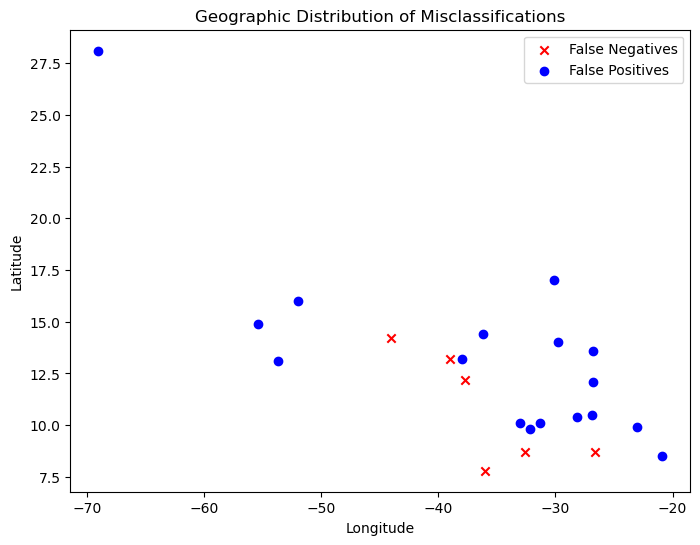

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


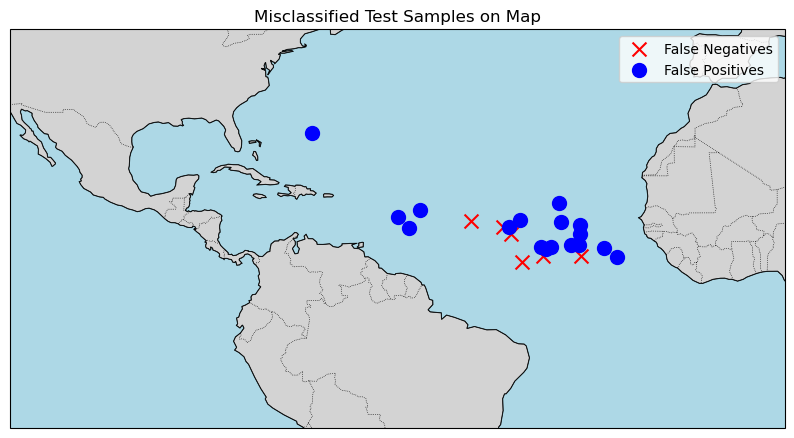

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

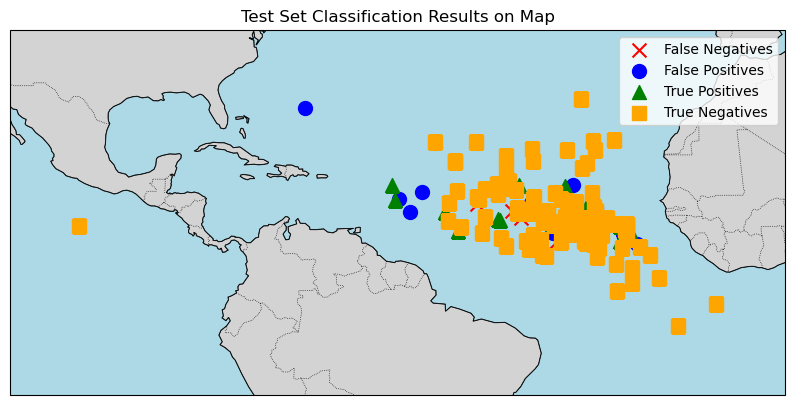

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [38]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 700
Unique latitudes: 196
Unique longitudes: 301


In [39]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
array([ 9.8, 14.6, 11.6,  8.4, 13.5,  9.9, 11.3, 20.7, 13.1, 19.4])
Coordinates:
    file_name   (sample) <U102 4kB ...
    lat_center  (sample) float64 80B ...
    lon_center  (sample) float64 80B ...
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B ...
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
array([-23.9, -33.4, -34.5, -32.2, -31. , -33.6, -22.3, -32.5, -30.3, -28.3])
Coordinates:
    file_name   (sample) <U102 4kB ...
    lat_center  (sample) float64 80B ...
    lon_center  (sample) float64 80B ...
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B ...


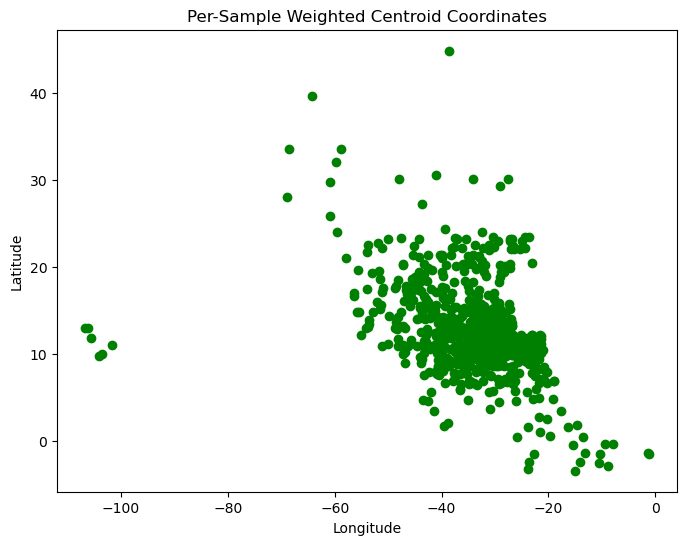

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [41]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.46186500787734985


Feature 0 - Increase in Loss: 0.09062396883964541


Feature 1 - Increase in Loss: -0.04266250133514404


Feature 2 - Increase in Loss: 0.019417780637741078


Feature 3 - Increase in Loss: 0.1543316602706909


Feature 4 - Increase in Loss: 0.012019014358520486


Feature 5 - Increase in Loss: 0.022651535272598278


Feature 6 - Increase in Loss: 0.09956357479095457


Feature 7 - Increase in Loss: -0.03499521017074586


Feature 8 - Increase in Loss: 0.05423152446746826


Feature 9 - Increase in Loss: 0.000624871253967263


Feature 10 - Increase in Loss: 0.22786619663238528


Feature 11 - Increase in Loss: 0.011946707963943481


Feature 12 - Increase in Loss: -0.04864052534103391


Feature 13 - Increase in Loss: 0.05841360688209529


Feature 14 - Increase in Loss: -0.009353268146514881


Feature 15 - Increase in Loss: 0.04521347880363469


Feature 16 - Increase in Loss: 0.007713830471038796


Feature 17 - Increase in Loss: -0.031498074531555176


Feature 18 - Increase in Loss: -0.03294104337692261
Permutation Importances (increase in loss) for all features: [ 0.09062397 -0.0426625   0.01941778  0.15433166  0.01201901  0.02265154
  0.09956357 -0.03499521  0.05423152  0.00062487  0.2278662   0.01194671
 -0.04864053  0.05841361 -0.00935327  0.04521348  0.00771383 -0.03149807
 -0.03294104]


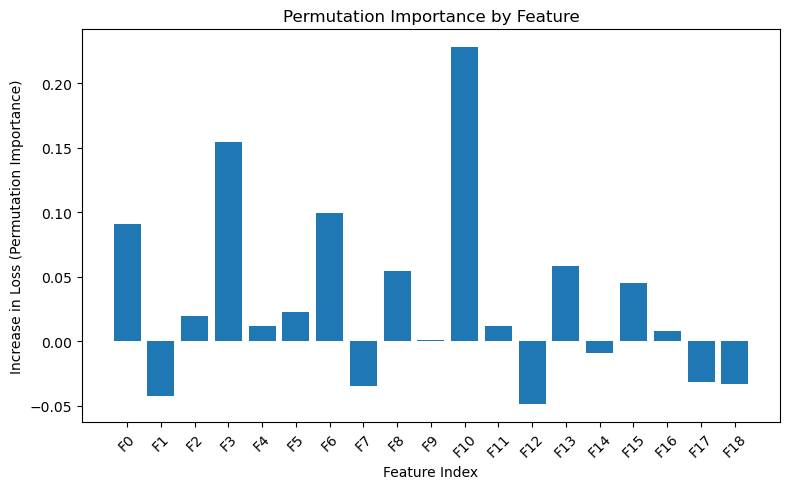

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


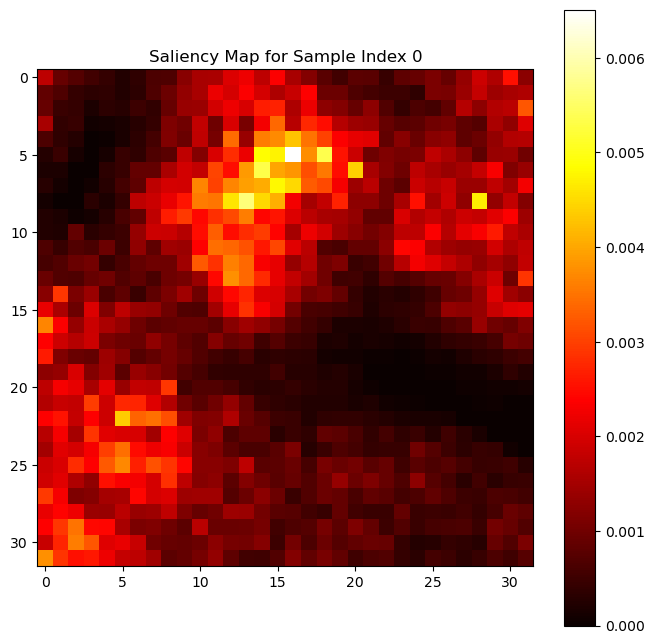

In [43]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



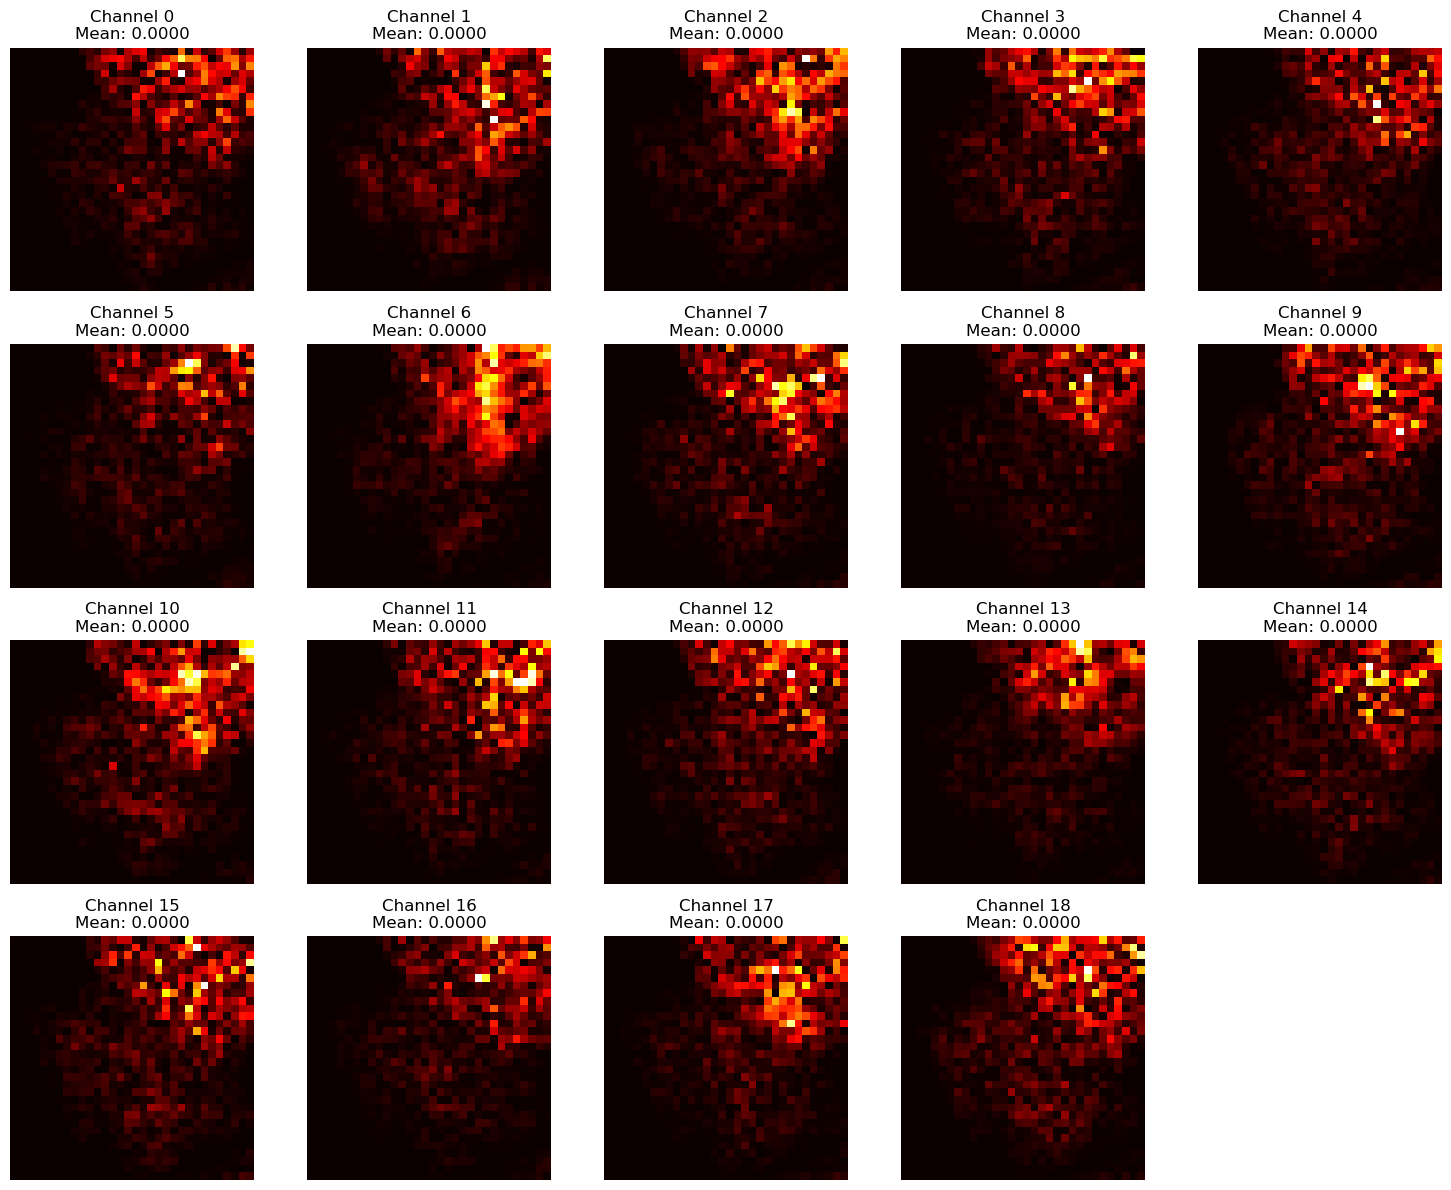

Channel importance (mean saliency per channel):
Channel 0: 0.0000
Channel 1: 0.0000
Channel 2: 0.0000
Channel 3: 0.0000
Channel 4: 0.0000
Channel 5: 0.0000
Channel 6: 0.0000
Channel 7: 0.0000
Channel 8: 0.0000
Channel 9: 0.0000
Channel 10: 0.0000
Channel 11: 0.0000
Channel 12: 0.0000
Channel 13: 0.0000
Channel 14: 0.0000
Channel 15: 0.0000
Channel 16: 0.0000
Channel 17: 0.0000
Channel 18: 0.0000


In [44]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


In [45]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))



/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Ensemble F1: 0.6486486486486487


{'loss': 0.46186500787734985, 'compile_metrics': 0.46186500787734985}
    f1_score  val_f1_score
95  0.903226      0.352941
96  0.901099      0.315789
97  0.886486      0.285714
98  0.902174      0.315789
99  0.907104      0.352941


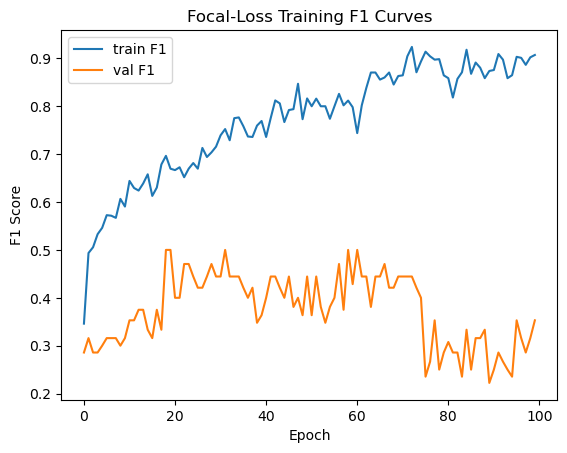

In [46]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


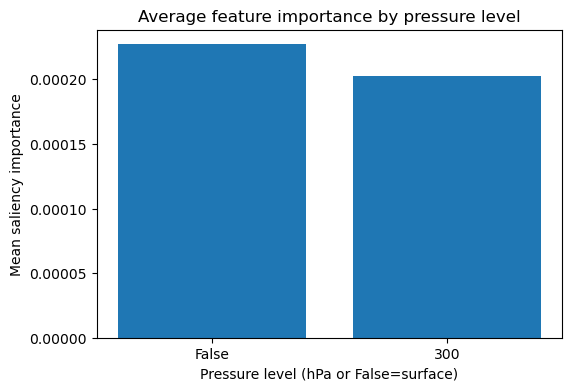

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()